# Importing Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import missingno as msno

from sklearn.preprocessing import QuantileTransformer,OneHotEncoder,KBinsDiscretizer,LabelEncoder
from feature_engine.encoding import RareLabelEncoder
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,GridSearchCV,train_test_split
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFECV
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from yellowbrick.model_selection import LearningCurve
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score,make_scorer,
                             precision_recall_curve, auc, f1_score, fbeta_score,roc_curve)

pd.options.display.max_columns = 100

# For model choosing:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB, MultinomialNB 
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis,LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier,ExtraTreesClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Handling Missing Values

In [10]:
data = pd.read_excel("train.xlsx")
df = data.copy()
df.head()

,ID,ncap rating,is power door locks,policyholder age,is parking camera,rear brakes type,is adjustable steering,is tpms,is driver seat height adjustable,segment,car age,is central locking,is rear window wiper,height,cluster area,is ecw,fuel type,torque,engine volume,transmission type,manufacturer,cylinder,is rear window washer,is front fog lights,is brake assist,is power steering,is esc,population,is rear window defogger,time period,engine type,is speed alert,steering type,length,width,is parking sensors,power,gross weight,is day night rear view mirror,model,gear box,airbags,turning radius,area danger level,is claim
0,0,2.0,Yes,0.394496,No,Drum,No,No,No,B1,0.08,Yes,No,1675.0,Area_8,Yes,CNG,82.1Nm@3400rpm,998.0,Manual,1.0,3.0,No,No,No,Yes,No,8883.0,No,0.304554,K10C,Yes,Power,3655.0,1620.0,Yes,55.92bhp@5300rpm,1340.0,No,Model_8,5.0,2.0,4.7,4,0
1,1,2.0,Yes,0.417364,No,Drum,No,No,No,B1,0.06,Yes,No,1675.0,Area_5,Yes,CNG,82.1Nm@3400rpm,998.0,Manual,1.0,3.0,No,No,No,Yes,No,34751.0,No,1.169197,K10C,Yes,Power,3655.0,1620.0,Yes,55.92bhp@5300rpm,1340.0,No,Model_8,5.0,2.0,4.7,1,1
2,2,2.0,Yes,0.438922,No,Drum,Yes,No,Yes,B2,0.03,Yes,No,1530.0,Area_2,Yes,Petrol,113Nm@4400rpm,1197.0,Manual,1.0,4.0,No,Yes,Yes,Yes,No,27026.0,No,1.219797,K Series Dual jet,Yes,Electric,3845.0,1735.0,Yes,88.50bhp@6000rpm,1335.0,Yes,Model_6,5.0,2.0,4.8,5,0
3,3,0.0,No,0.656276,No,Drum,No,No,No,A,0.04,No,No,1475.0,Area_13,No,CNG,60Nm@3500rpm,796.0,Manual,1.0,3.0,No,No,No,Yes,No,5482.0,No,0.746151,F8D Petrol Engine,Yes,Power,3445.0,1515.0,Yes,40.36bhp@6000rpm,1185.0,No,Model_1,5.0,2.0,4.6,2,0
4,4,3.0,Yes,0.462328,Yes,Disc,Yes,Yes,Yes,C2,0.04,Yes,Yes,1635.0,Area_9,Yes,Diesel,250Nm@2750rpm,1493.0,Automatic,3.0,4.0,Yes,Yes,Yes,Yes,Yes,17833.0,Yes,0.171981,1.5 L U2 CRDi,Yes,Power,4300.0,1790.0,Yes,113.45bhp@4000rpm,1720.0,No,Model_4,6.0,6.0,5.2,3,0


In [11]:
df.columns = df.columns.str.replace(" ", "_")
df.isnull().sum()

ID                                    0
ncap_rating                          99
is_power_door_locks                  94
policyholder_age                     81
is_parking_camera                    83
rear_brakes_type                     86
is_adjustable_steering               90
is_tpms                              89
is_driver_seat_height_adjustable     85
segment                              83
car_age                             105
is_central_locking                   89
is_rear_window_wiper                 69
height                               96
cluster_area                         85
is_ecw                               85
fuel_type                            89
torque                               76
engine_volume                       103
transmission_type                    97
manufacturer                         87
cylinder                             97
is_rear_window_washer                89
is_front_fog_lights                  86
is_brake_assist                     105


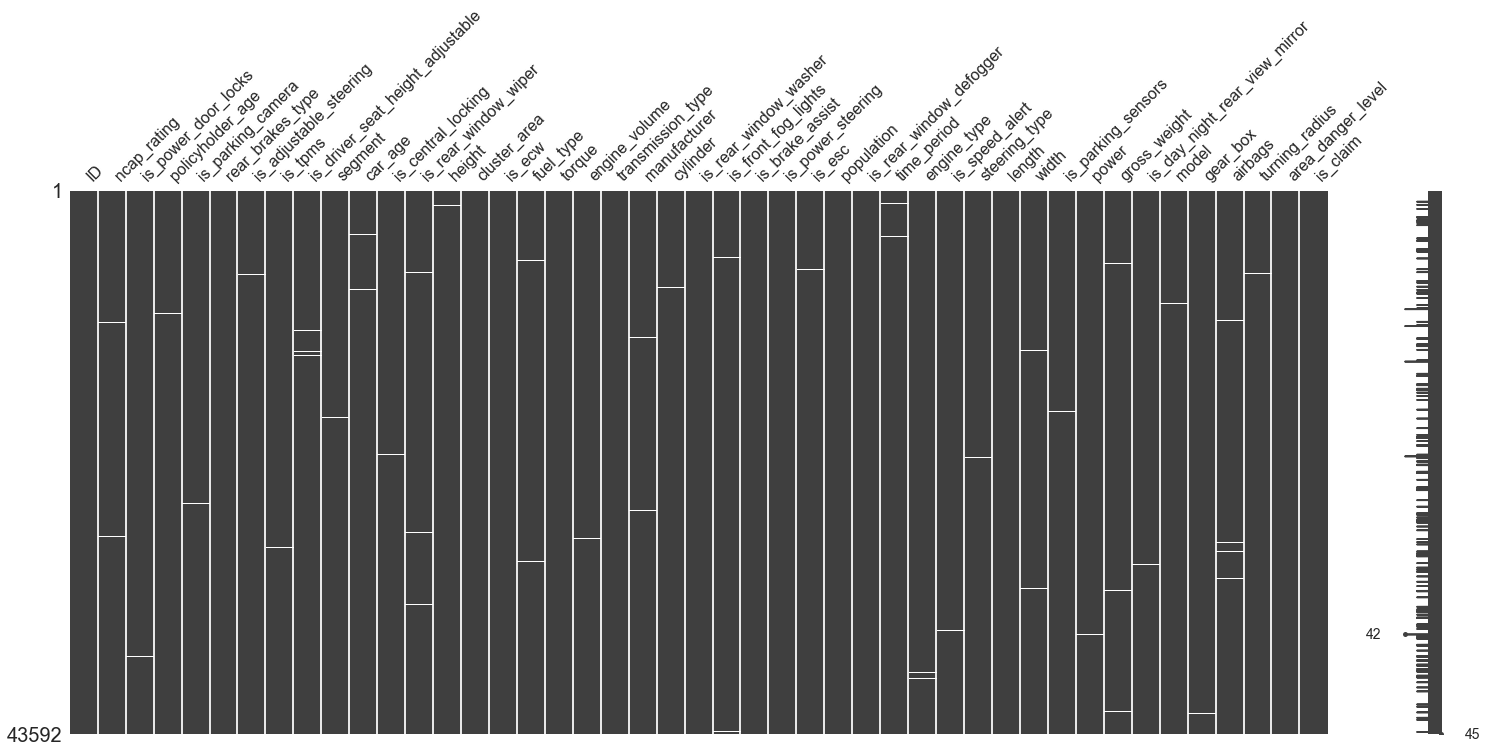

In [5]:
msno.matrix(df);

**<span style="color:blue">Nullity correlation check</span>**

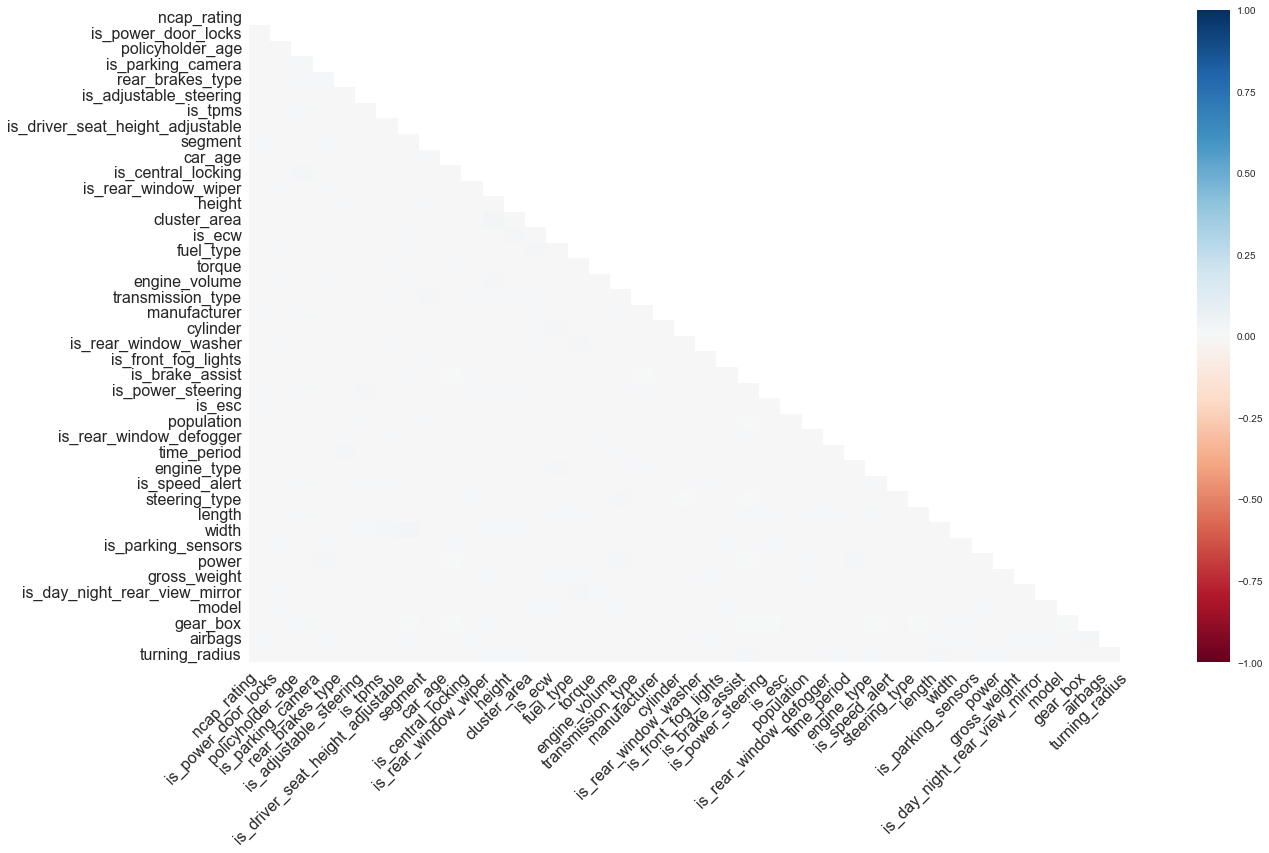

In [6]:
msno.heatmap(df);

In [15]:
#df.drop("ID",axis=1,inplace=True)

# Models list:
models = df.model.dropna().unique().tolist()

# For each model, appending model related features to handle relative missing values:
infos = {}

for i in models:
    for (k,j) in df[df.model == i].items():
        if j.nunique() == 1 and k != "model":
            if i not in infos:
                infos[i] = [j.unique()[0]]
            else:
                infos[i].append(j.unique()[0])     
                
model_related_feats = []

for (i,j) in df[df.model == "Model_1"].items():
    if j.nunique() == 1 and i != "model":
        model_related_feats.append(i)
        
# Creating DF as model related features catalog:        
model_filler = pd.DataFrame(infos)
model_filler.index = model_related_feats
model_filler

,Model_8,Model_6,Model_1,Model_4,Model_7,Model_5,Model_10,Model_3,Model_9,Model_2,Model_11
ncap_rating,2.0,2.0,0.0,3.0,0.0,5.0,0.0,2.0,4.0,2.0,5.0
is_power_door_locks,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes
is_parking_camera,No,No,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes
rear_brakes_type,Drum,Drum,Drum,Disc,Drum,Drum,Drum,Drum,Drum,Drum,Drum
is_adjustable_steering,No,Yes,No,Yes,Yes,Yes,No,No,Yes,Yes,No
is_tpms,No,No,No,Yes,No,No,No,No,No,No,No
is_driver_seat_height_adjustable,No,Yes,No,Yes,Yes,No,No,No,Yes,Yes,Yes
segment,B1,B2,A,C2,B2,B2,Utility,A,C1,C1,C1
is_central_locking,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes
is_rear_window_wiper,No,No,No,Yes,Yes,No,No,No,No,No,No


In [16]:
# Filling missing values in "Model" column according to the "engine_type" as it's an unique information for model type.

idx = df[df.loc[:,'model'].isnull()].index

for i in idx:
    engine = df.loc[i,'engine_type']
    model = model_filler.columns[model_filler.loc['engine_type'] == engine][0]
    df.loc[i,'model'] = model

In [17]:
# Filling missing values in "model related features" with the values in info dict(model_filler dataframe):

for i in df.columns:
    idx = df[df.loc[:,i].isnull()].index
    for j in idx:
        try:
            model = df.loc[j,'model']
        except:
            continue
        try:
            df.loc[j,i] = model_filler.loc[i,model]
        except:
            continue

In [18]:
# Checking relation with cluster_area and population: 

means = df.groupby(by="cluster_area")["population"].mean().tolist()
maxs = df.groupby(by="cluster_area")["population"].max().tolist()
mins = df.groupby(by="cluster_area")["population"].min().tolist()
x = pd.DataFrame(df.groupby(by="cluster_area")["population"].min())
x.columns = ["mins"]
x["maxs"] = maxs
x["means"] = means
x

,mins,maxs,means
cluster_area,,,
Area_1,4991.0,5089.0,5040.192518
Area_10,73431.0,73529.0,73479.684615
Area_11,6109.0,6207.0,6158.981111
Area_12,34792.0,34890.0,34841.078856
Area_13,5411.0,5509.0,5459.975348
Area_14,7789.0,7887.0,7837.842318
Area_15,291.0,389.0,340.294118
Area_16,16207.0,16305.0,16257.966667
Area_17,65568.0,65666.0,65617.544737


In [19]:
# Filling missing values with the mean of same cluster_area in population variable:
df.population = df.population.fillna(df.groupby('cluster_area')['population'].transform('mean'))

# Checking the population value in the relevant cell from the X dataframe, which shows the mins and maxes
# according to the clusters, and fill it whichever range is appropriate for the cluster.  
idx = df[df.loc[:,'cluster_area'].isnull()].index

for i in idx:
    pop = df.loc[i,'population']
    a = 0
    for j in x.index:
        if pop >= x.iloc[a,0] and pop <= x.iloc[a,1]:
            df.loc[i,'cluster_area'] = x.index[a]
        a += 1

In [20]:
df[df.columns[df.isna().sum()>0]].isna().sum()

policyholder_age     81
car_age             105
time_period          82
dtype: int64

In [21]:
# Now we have only 3 variables that have missing values and they are all numarical

# Variable seperation
nums = []
cats = []
for i in df.columns:
        if df[i].dtype != "O" and i!="is_claim":
            nums.append(i)   
        elif i != "is_claim":
            cats.append(i)
            
# Using iterative imputer with XGBRegressor
base_df = df.copy()


estimator = XGBRegressor()
model_imputer = IterativeImputer(estimator=estimator).fit(base_df[nums])
df_filled2 = model_imputer.transform(base_df[nums])
df_filled2 = pd.DataFrame(df_filled2, columns=base_df[nums].columns)

base_df[["time_period","policyholder_age","car_age"]] = df_filled2[["time_period","policyholder_age","car_age"]]
base_df[base_df.columns[base_df.isnull().sum()>0]].isnull().sum()

Series([], dtype: float64)

In [30]:
nums = []
cats = []
for i in base_df.columns:
        if base_df[i].dtype != "O" and i!="is_claim":
            nums.append(i)   
        elif i != "is_claim":
            cats.append(i)

In [31]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43592 entries, 0 to 43591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ncap_rating                       43592 non-null  float64
 1   is_power_door_locks               43592 non-null  object 
 2   policyholder_age                  43592 non-null  float64
 3   is_parking_camera                 43592 non-null  object 
 4   rear_brakes_type                  43592 non-null  object 
 5   is_adjustable_steering            43592 non-null  object 
 6   is_tpms                           43592 non-null  object 
 7   is_driver_seat_height_adjustable  43592 non-null  object 
 8   segment                           43592 non-null  object 
 9   car_age                           43592 non-null  float64
 10  is_central_locking                43592 non-null  object 
 11  is_rear_window_wiper              43592 non-null  object 
 12  heig

<div class="alert alert-block alert-success">
<h1 style="color:green;font-size:40px;">No missing value in train data at this point.</h1>      
</div>

# Creating Base Models To Choose Algorithm

In [24]:
def print_results(headline, true_value, pred, probs):
    scores=[]
    CM = confusion_matrix(true_value, pred)
    scores.append(headline)
    scores.append(accuracy_score(true_value, pred))
    scores.append(int(CM[1,1]))
    scores.append(int(CM[0,1]))
    scores.append(int(CM[0][0]))
    scores.append(int(CM[1][0]))
    scores.append(precision_score(true_value, pred))
    scores.append(recall_score(true_value, pred))
    scores.append(roc_auc_score(true_value, probs))
    p, r, _ = precision_recall_curve(true_value, probs)
    scores.append(auc(r,p))
    scores.append(f1_score(true_value, pred))
    scores.append(fbeta_score(true_value, pred, beta=2)) 
    return scores
score_names = ['method','accuracy','TP','FP','TN','FN','precision','recall','roc_auc','pr_auc','f1', 'f2']

In [25]:
basemodel_comparison_df = pd.DataFrame(data=np.zeros(shape=(0,12)), columns = score_names)

In [26]:
classifier_list = [KNeighborsClassifier(),DecisionTreeClassifier(random_state=42),GaussianNB(),BernoulliNB(),
                   RandomForestClassifier(random_state=42),XGBClassifier(),LGBMClassifier(random_state=42),
                   SVC(random_state=42,probability=True),QuadraticDiscriminantAnalysis(),
                   LinearDiscriminantAnalysis(), BaggingClassifier(random_state=42), ExtraTreesClassifier(random_state=42),
                   AdaBoostClassifier(random_state=42),GradientBoostingClassifier(random_state=42), 
                   MLPClassifier(random_state=42),LogisticRegression(random_state=42)]

classifier_names = ["KNeighbors","DTC","GausNB","BerNB","RFC","XGB","LGBM","SVC","Quad","LDA","Bagging","ExtraTC","Ada",
                    "GBC","MLP","Log-Reg"]

In [28]:
nums = []
cats = []
for i in base_df.columns:
        if base_df[i].dtype != "O" and i!="is_claim":
            nums.append(i)   
        elif i != "is_claim":
            cats.append(i)
 

train, test = train_test_split(base_df, test_size=0.10, random_state=42, stratify=base_df.is_claim)

y_train = train.is_claim
X_train = train.drop('is_claim', axis=1)
y_test = test.is_claim
X_test = test.drop('is_claim', axis=1)

a = 0
for i in classifier_list:
        num_transformer = Pipeline(steps=[('scale',  QuantileTransformer(output_distribution='normal'))])
        cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])
        preprocessor = ColumnTransformer(transformers=[('categorical', cat_transformer, cats),
                                                       ('numerical', num_transformer, nums)],
                                                       remainder = 'passthrough') 

        pipeline = Pipeline([('preprocessor' , preprocessor),
                               ('classifier' , i)])


        model = pipeline.fit(X_train, y_train)

        pred_probs = model.predict_proba(X_test)[:,1]
        scores = print_results(classifier_names[a], y_test, model.predict(X_test), pred_probs)
        dftmp = pd.DataFrame([scores], columns=score_names)
        basemodel_comparison_df = pd.concat([basemodel_comparison_df, dftmp], ignore_index=True)
        a += 1

In [29]:
basemodel_comparison_df.sort_values(by="roc_auc",ascending=False)

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
13,GBC,0.936009,0.0,0.0,4081.0,279.0,0.000000,0.000000,0.660315,0.106569,0.000000,0.000000
6,LGBM,0.936009,0.0,0.0,4081.0,279.0,0.000000,0.000000,0.642016,0.098318,0.000000,0.000000
15,Log-Reg,0.936009,0.0,0.0,4081.0,279.0,0.000000,0.000000,0.627270,0.090996,0.000000,0.000000
9,LDA,0.935780,0.0,1.0,4080.0,279.0,0.000000,0.000000,0.625741,0.089789,0.000000,0.000000
12,Ada,0.936009,0.0,0.0,4081.0,279.0,0.000000,0.000000,0.623902,0.085835,0.000000,0.000000
14,MLP,0.934862,1.0,6.0,4075.0,278.0,0.142857,0.003584,0.622332,0.091560,0.006993,0.004452
5,XGB,0.935321,0.0,3.0,4078.0,279.0,0.000000,0.000000,0.621809,0.093144,0.000000,0.000000
4,RFC,0.935550,0.0,2.0,4079.0,279.0,0.000000,0.000000,0.609497,0.092308,0.000000,0.000000
10,Bagging,0.934174,0.0,8.0,4073.0,279.0,0.000000,0.000000,0.571897,0.085635,0.000000,0.000000
0,KNeighbors,0.933486,4.0,15.0,4066.0,275.0,0.210526,0.014337,0.566729,0.103511,0.026846,0.017621


<div class="alert alert-block alert-success">
<h1 style="color:green;font-size:30px;">Selected Model:</h1>
We choose the Light GBM model because our data is large, there is no decisive difference between the models and the target is in an imbalance structure, and we will continue with this model from now on.
</div>

# Exploratory Data Analysis

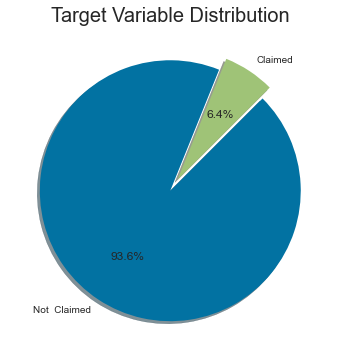

In [32]:
labels = ["Not  Claimed","Claimed"]
plt.figure(figsize=(6,6))
plt.title("Target Variable Distribution",fontsize=20)
plt.pie(base_df.is_claim.value_counts(),labels = labels, 
        counterclock=False, shadow=True, autopct='%1.1f%%', radius=1,explode=[0,0.1],startangle=45)
plt.show()

In [33]:
# Dealing with 'torque' and 'power':

# Torque: 82.1Nm@3400rpm
# While 82.1 nm shows torque value, @3400 RPM shows the engine speed at which this torque value occurs. 
# So we will keep the torque information in the torque section.

# Power: 55.92bhp@5300rpm
# While 55.92 shows the brake horse power, RPM indicates the highest engine speed with BHP occurs.
# So we will keep RPM as "rpm" and BHP info as "performance".

df1 = base_df.copy()

df1.power = df1.power.str.replace("bhp","").str.replace("rpm","")
df1.torque = df1.torque.str.replace("Nm","").str.replace("rpm","")
df1.torque = df1.torque.str.split('@').str[0].astype(float)
df1["performance"] = df1.power.str.split('@').str[0].astype(float)
df1["rpm"] = df1.power.str.split('@').str[1].astype(float)
df1.drop("power",axis=1,inplace=True)

# Create a density-like feature
df1["dens"] = round(df1.gross_weight / ((df1.height * df1.width * df1.length)**(1/3)),4)

# Experimental features
df1["pol_time"] = (df1.policyholder_age*df1.time_period)**0.5
df1["carage_time"] = (df1.time_period*df1.car_age)**0.5

In [34]:
for i in df1.columns:
    print(i, df1[i].nunique())

ncap_rating 5
is_power_door_locks 2
policyholder_age 43592
is_parking_camera 2
rear_brakes_type 2
is_adjustable_steering 2
is_tpms 2
is_driver_seat_height_adjustable 2
segment 6
car_age 153
is_central_locking 2
is_rear_window_wiper 2
height 11
cluster_area 22
is_ecw 2
fuel_type 3
torque 8
engine_volume 9
transmission_type 2
manufacturer 5
cylinder 2
is_rear_window_washer 2
is_front_fog_lights 2
is_brake_assist 2
is_power_steering 2
is_esc 2
population 1968
is_rear_window_defogger 2
time_period 43592
engine_type 11
is_speed_alert 2
steering_type 3
length 9
width 10
is_parking_sensors 2
gross_weight 10
is_day_night_rear_view_mirror 2
model 11
gear_box 2
airbags 3
turning_radius 9
area_danger_level 5
is_claim 2
performance 9
rpm 5
dens 11
pol_time 43592
carage_time 39739


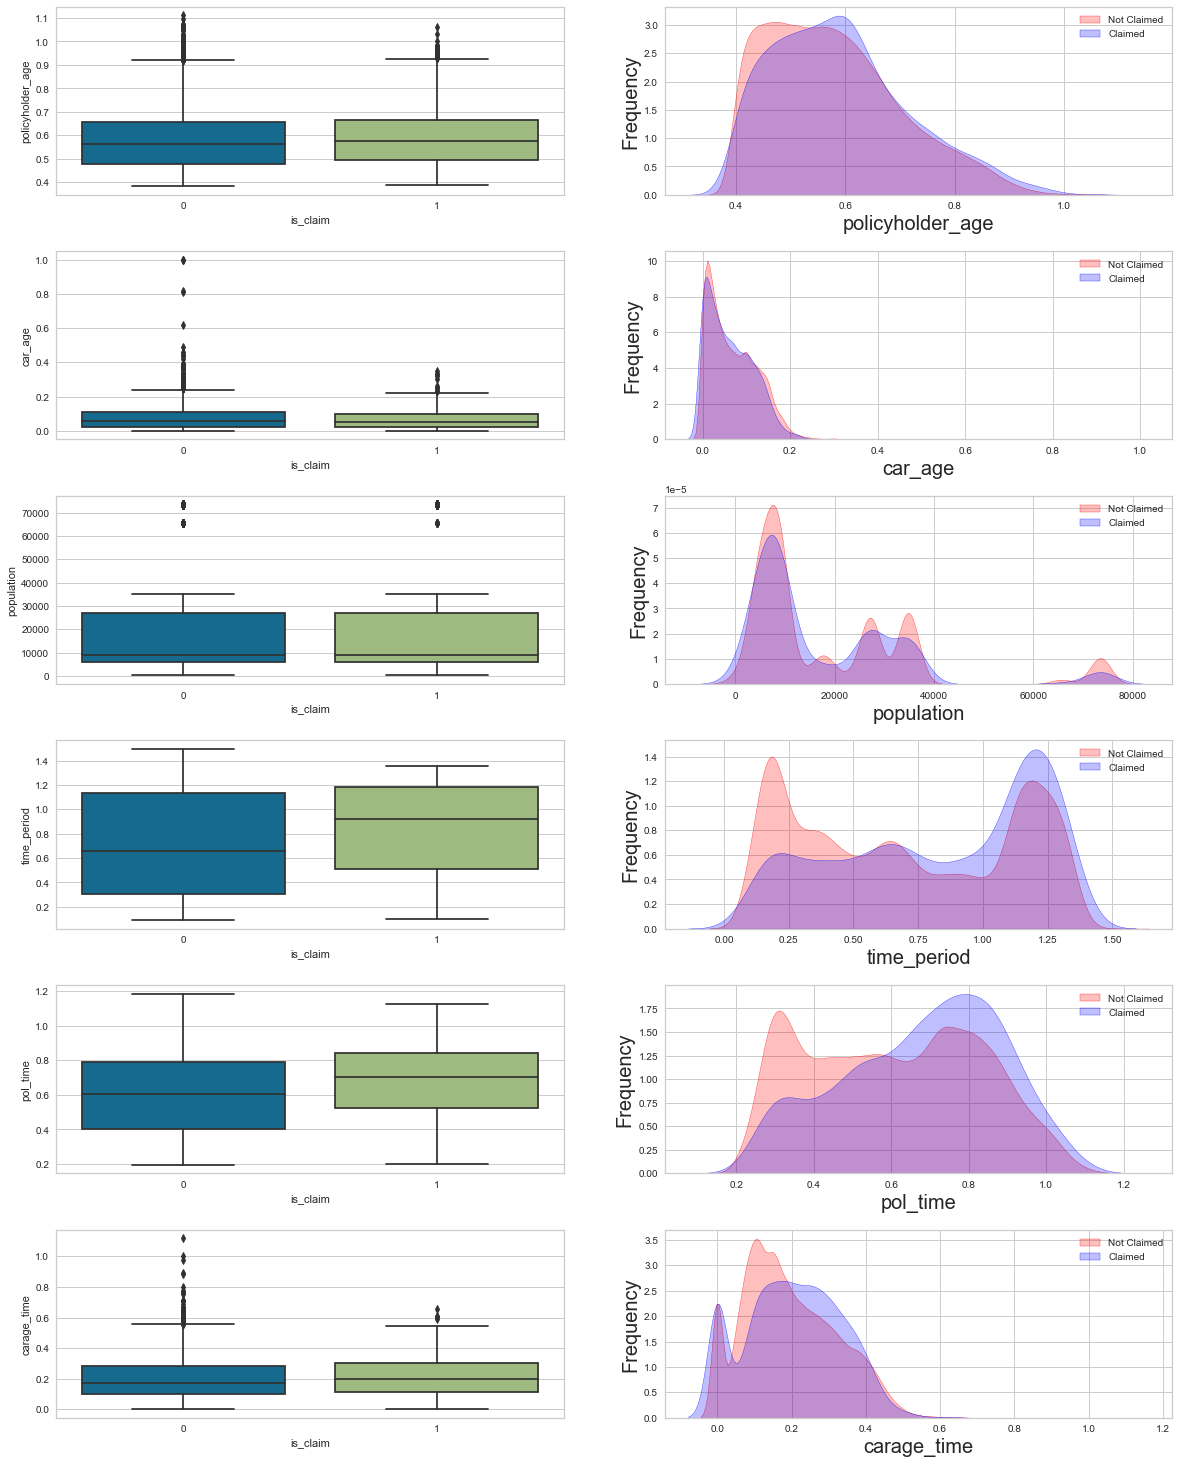

In [35]:
really_nums = []
for i in df1.columns:
    if df1[i].nunique() > 30:
        really_nums.append(i)
        
plt.figure(figsize=(20, 20))
count = 1
for cols in really_nums:
    plt.subplot(6, 2, count)
    sns.boxplot(x='is_claim', y= cols, data= df1)
    count +=1
    plt.subplot(6, 2, count)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.2)

    g = sns.kdeplot(df1[cols][(df1["is_claim"] == 0) ], color="Red", shade = True)
    g = sns.kdeplot(df1[cols][(df1["is_claim"] == 1) ], ax =g, color="Blue", shade= True)
    g.set_xlabel(cols,fontsize = 20)
    g.set_ylabel("Frequency",fontsize = 20)
    g = g.legend(["Not Claimed","Claimed"])
    count+=1

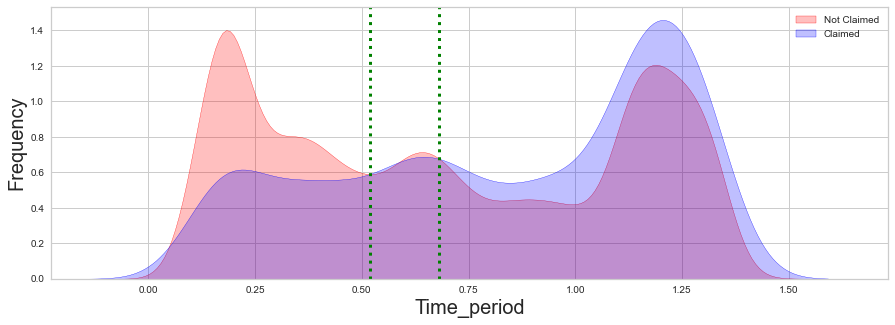

In [36]:
plt.figure(figsize=(15, 5))
g = sns.kdeplot(df1.time_period[(df1.is_claim == 0) ], color="Red", shade = True)
g = sns.kdeplot(df1.time_period[(df1.is_claim == 1) ], ax =g, color="Blue", shade= True)
g.axvline(x = 0.68, color ="green", linestyle =":",lw=3)
g.axvline(x = 0.52, color ="green", linestyle =":",lw=3)
g.set_xlabel("Time_period",fontsize = 20)
g.set_ylabel("Frequency",fontsize = 20)
g = g.legend(["Not Claimed","Claimed"])

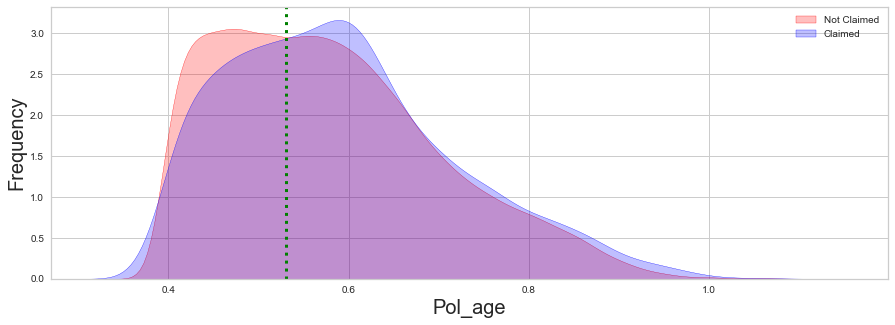

In [37]:
plt.figure(figsize=(15, 5))
g = sns.kdeplot(df1.policyholder_age[(df1.is_claim == 0) ], color="Red", shade = True)
g = sns.kdeplot(df1.policyholder_age[(df1.is_claim == 1) ], ax =g, color="Blue", shade= True)
g.axvline(x = 0.53, color ="green", linestyle =":",lw=3)
g.set_xlabel("Pol_age",fontsize = 20)
g.set_ylabel("Frequency",fontsize = 20)
g = g.legend(["Not Claimed","Claimed"])

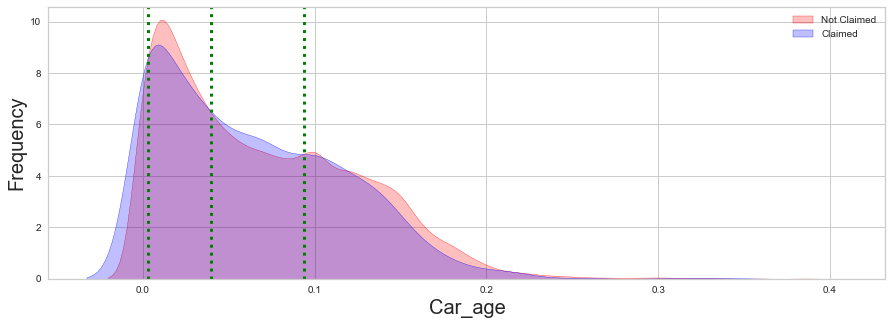

In [38]:
car_age_df = df1[df1.car_age < 0.4]

plt.figure(figsize=(15, 5))
g = sns.kdeplot(car_age_df.car_age[(car_age_df.is_claim == 0)], color="Red", shade = True)
g = sns.kdeplot(car_age_df.car_age[(car_age_df.is_claim == 1)], ax =g, color="Blue", shade= True)
g.axvline(x = 0.003, color ="green", linestyle =":",lw=3)
g.axvline(x = 0.04, color ="green", linestyle =":",lw=3)
g.axvline(x = 0.094, color ="green", linestyle =":",lw=3)
g.set_xlabel("Car_age",fontsize = 20)
g.set_ylabel("Frequency",fontsize = 20)
g = g.legend(["Not Claimed","Claimed"])

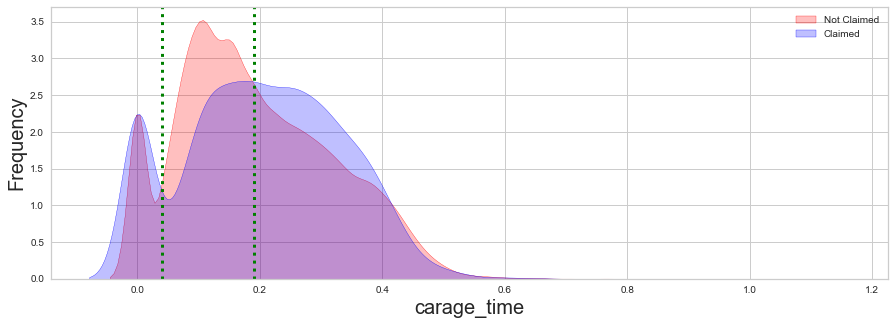

In [39]:
plt.figure(figsize=(15, 5))
g = sns.kdeplot(df1.carage_time[(df1.is_claim == 0) ], color="Red", shade = True)
g = sns.kdeplot(df1.carage_time[(df1.is_claim == 1) ], ax =g, color="Blue", shade= True)
g.axvline(x = 0.04, color ="green", linestyle =":",lw=3)
g.axvline(x = 0.19, color ="green", linestyle =":",lw=3)
g.set_xlabel("carage_time",fontsize = 20)
g.set_ylabel("Frequency",fontsize = 20)
g = g.legend(["Not Claimed","Claimed"])

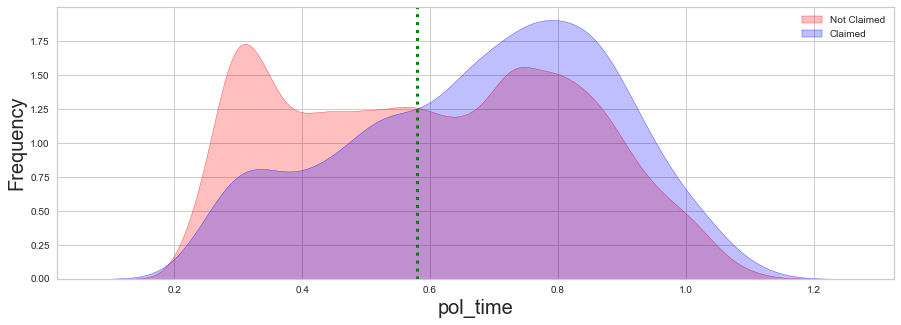

In [40]:
plt.figure(figsize=(15, 5))
g = sns.kdeplot(df1.pol_time[(df1.is_claim == 0) ], color="Red", shade = True)
g = sns.kdeplot(df1.pol_time[(df1.is_claim == 1) ], ax =g, color="Blue", shade= True)
g.axvline(x = 0.58, color ="green", linestyle =":",lw=3)
g.set_xlabel("pol_time",fontsize = 20)
g.set_ylabel("Frequency",fontsize = 20)
g = g.legend(["Not Claimed","Claimed"])

In [41]:
# Although the cluster area variable is categorical, since it contains 22 unique values, 
# we create a new feature as the ones above and below the average claim threshold.

cluster_df = pd.crosstab(df1.cluster_area, df1.is_claim)
cluster_df["ratio"] = round(cluster_df[1] / (cluster_df[0] + cluster_df[1]) * 100,2)
cluster_df = cluster_df.sort_values(by="ratio",ascending=False)
cluster_df

is_claim,0,1,ratio
cluster_area,,,
Area_18,160,15,8.57
Area_19,642,54,7.76
Area_3,4131,330,7.40
Area_2,5115,402,7.29
Area_14,2544,194,7.09
Area_22,145,11,7.05
Area_8,9508,718,7.02
Area_21,256,19,6.91
Area_11,847,56,6.20


In [42]:
thold = 6.4
cluster_over = cluster_df[cluster_df.ratio > thold].index.tolist()
cluster_ratio = []
for i in df1.cluster_area:
    if i in cluster_over:
        cluster_ratio.append("Up")
    else:
        cluster_ratio.append("Down")
df1["cluster_ratio"] = cluster_ratio

In [43]:
# For 5 continuous variables, we create new variables within the thresholds drawn in the graphs above.

time_labels = []
for i in df1.time_period:
    if i < 0.52:
        time_labels.append("label1")
    elif i < 0.68:
        time_labels.append("label2")
    else:
        time_labels.append("label3")
        
df1["time_labels"] = time_labels


polage_labels = []
for i in df1.policyholder_age:
    if i < 0.53:
        polage_labels.append("label1")
    else:
        polage_labels.append("label2")
        
df1["polage_labels"] = polage_labels


carage_labels = []
for i in df1.car_age:
    if i < 0.003:
        carage_labels.append("label1")
    elif i < 0.04:
        carage_labels.append("label2")
    elif i < 0.094:
        carage_labels.append("label3")       
    else:
        carage_labels.append("label4")
        
df1["carage_labels"] = carage_labels


pol_time_labels = []
for i in df1.pol_time:
    if i > 0.058:
        pol_time_labels.append("label1")   
    else:
        pol_time_labels.append("label2")
        
df1["pol_time_labels"] = pol_time_labels



carage_time_labels = []
for i in df1.carage_time:
    if i < 0.04:
        carage_time_labels.append("label1")
    elif i < 0.19:
        carage_time_labels.append("label2")
    else:
        carage_time_labels.append("label3")
        
df1["carage_time_labels"] = carage_time_labels

In [44]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43592 entries, 0 to 43591
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ncap_rating                       43592 non-null  float64
 1   is_power_door_locks               43592 non-null  object 
 2   policyholder_age                  43592 non-null  float64
 3   is_parking_camera                 43592 non-null  object 
 4   rear_brakes_type                  43592 non-null  object 
 5   is_adjustable_steering            43592 non-null  object 
 6   is_tpms                           43592 non-null  object 
 7   is_driver_seat_height_adjustable  43592 non-null  object 
 8   segment                           43592 non-null  object 
 9   car_age                           43592 non-null  float64
 10  is_central_locking                43592 non-null  object 
 11  is_rear_window_wiper              43592 non-null  object 
 12  heig

In [45]:
# Cluster Area + Area Danger Level examination

table = pd.pivot_table(df1[['cluster_area','area_danger_level','is_claim']],index=['cluster_area',"area_danger_level"],
                       aggfunc=['count', 'sum'])
table["ratio"] = table[('sum', 'is_claim')] / table[('count', 'is_claim')] * 100
table[table.ratio > 7].sort_values(by="ratio",ascending=False)

,,count,sum,ratio
,,is_claim,is_claim,
cluster_area,area_danger_level,,,
Area_18,5,32,5,15.625000
Area_21,5,57,8,14.035088
Area_22,5,36,4,11.111111
Area_20,3,9,1,11.111111
Area_19,3,143,14,9.790210
Area_6,1,125,12,9.600000
Area_19,2,128,12,9.375000
Area_18,2,44,4,9.090909


In [46]:
df1["areas"] = np.where(((df1.cluster_area == "Area_18") & (df1.area_danger_level == 5)) |
                        ((df1.cluster_area == "Area_21") & (df1.area_danger_level == 5)) |
                        ((df1.cluster_area == "Area_22") & (df1.area_danger_level == 5)) |
                        ((df1.cluster_area == "Area_20") & (df1.area_danger_level == 3)), 
                        "label1",
                        np.where(((df1.cluster_area == "Area_19") & (df1.area_danger_level == 3)) |
                                 ((df1.cluster_area == "Area_6") & (df1.area_danger_level == 1)) |
                                 ((df1.cluster_area == "Area_19") & (df1.area_danger_level == 2)) |
                                 ((df1.cluster_area == "Area_18") & (df1.area_danger_level == 2)), 
                                 "label2",
                                 np.where(((df1.cluster_area == "Area_4") & (df1.area_danger_level == 1)) |
                                          ((df1.cluster_area == "Area_3") & (df1.area_danger_level == 2)) |
                                          ((df1.cluster_area == "Area_21") & (df1.area_danger_level == 1)) |
                                          ((df1.cluster_area == "Area_22") & (df1.area_danger_level == 2)) |
                                          ((df1.cluster_area == "Area_11") & (df1.area_danger_level == 4)) |
                                          ((df1.cluster_area == "Area_22") & (df1.area_danger_level == 1)) |
                                          ((df1.cluster_area == "Area_11") & (df1.area_danger_level == 3)) |
                                          ((df1.cluster_area == "Area_12") & (df1.area_danger_level == 2)) |
                                          ((df1.cluster_area == "Area_18") & (df1.area_danger_level == 1)) |
                                          ((df1.cluster_area == "Area_3") & (df1.area_danger_level == 3)), 
                                          "label3",
                                          np.where(((df1.cluster_area == "Area_3") & (df1.area_danger_level == 4)) |
                                                   ((df1.cluster_area == "Area_13") & (df1.area_danger_level == 5)) |
                                                   ((df1.cluster_area == "Area_19") & (df1.area_danger_level == 1)) |
                                                   ((df1.cluster_area == "Area_2") & (df1.area_danger_level == 5)) |
                                                   ((df1.cluster_area == "Area_2") & (df1.area_danger_level == 4)) |
                                                   ((df1.cluster_area == "Area_14") & (df1.area_danger_level == 1)) |
                                                   ((df1.cluster_area == "Area_15") & (df1.area_danger_level == 3)) |
                                                   ((df1.cluster_area == "Area_8") & (df1.area_danger_level == 5)) |
                                                   ((df1.cluster_area == "Area_2") & (df1.area_danger_level == 1)) |
                                                   ((df1.cluster_area == "Area_8") & (df1.area_danger_level == 3)) |
                                                   ((df1.cluster_area == "Area_14") & (df1.area_danger_level == 5)) |
                                                   ((df1.cluster_area == "Area_2") & (df1.area_danger_level == 3)) |
                                                   ((df1.cluster_area == "Area_14") & (df1.area_danger_level == 4)) |
                                                   ((df1.cluster_area == "Area_11") & (df1.area_danger_level == 2)) ,                                                 
                                                   "label4", "label5" ))))

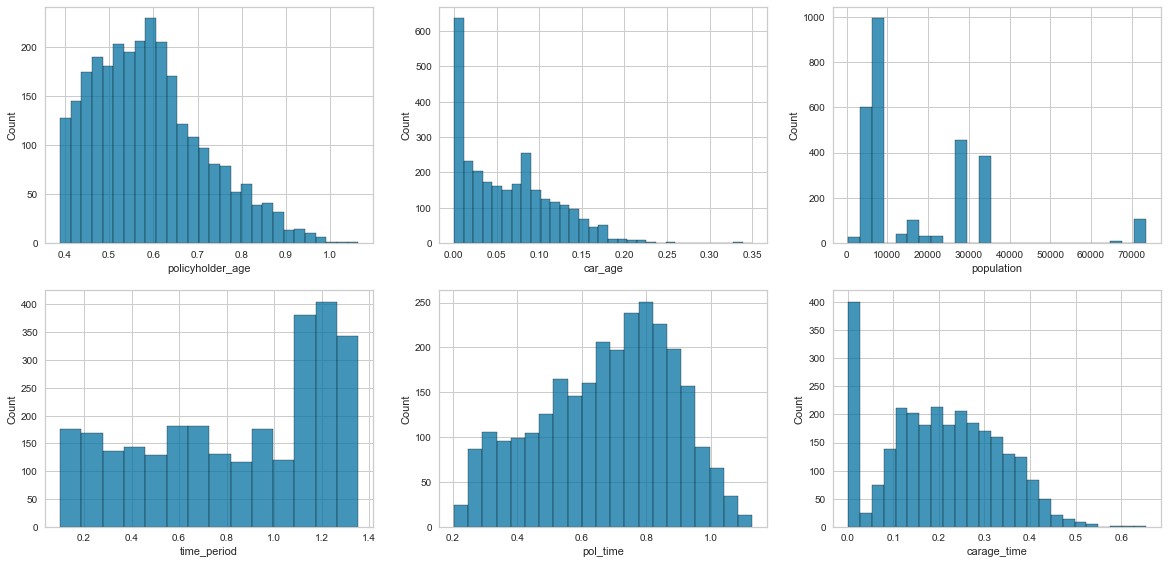

In [47]:
# Since we are dealing with unbalanced data, we want to look at the variable distribution of only claimed ones.

df_claims = df1[df1.is_claim == 1]
plt.figure(figsize=(20,20))
a = 1
for i in really_nums:
    plt.subplot(4,3,a)
    sns.histplot(df_claims[i])
    a += 1

In [48]:
# We create additional features for the 4 continuous variables that were in the original DF according to the graphs above

df1["new_car"] = np.where(df1.car_age == 0.00,"Yes","No")
df1["young"] = np.where(df1.policyholder_age < 0.64,"Yes","No")
df1["long_period"] = np.where(df1.time_period >= 1.104,"Yes","No")
df1["pop_area"] = np.where((df1.population > (7620-750)) & (df1.population < (7620+750)),"Yes","No")

In [49]:
# It is essentially a categorical variable

manu_map = {1.0 : "A",
            2.0 : "B",
            3.0 : "C",
            4.0 : "D",
            5.0 : "E"}

df1["manufacturer"] = df1.manufacturer.map(manu_map)

In [50]:
# For continuous variables, we create new variables using KBinsDiscretizer

est = KBinsDiscretizer(n_bins=35, encode='ordinal', strategy='kmeans')
est.fit(df1[["policyholder_age","car_age","height","population","time_period","dens","pol_time","carage_time"]])
buckets = est.transform(df1[["policyholder_age","car_age","height","population","time_period","dens","pol_time","carage_time"]])
buckets = pd.DataFrame(buckets,columns=["policyholder_age2","car_age2","height2","population2","time_period2","dens2","pol_time2","carage_time2"])
df2 = pd.concat([df1,buckets],axis=1)

<div class="alert alert-block alert-success">
<h1 style="color:green;font-size:30px;">Features:</h1>
We have completed our feature engineering work. "df2" is our new base DF. 
Since we will examine the variables again using the feature importance method of Light GBM, at this point, we move on to creating models without further exploratory analysis.
</div>

# Model Trials

**<span style="color:blue">Model-1</span>**

In [51]:
for i in df2.columns:
    if df2[i].dtype == "O":
        df2[i] = df2[i].astype("category")
        
nums = []
cats = []
for i in df2.columns:
        if df2[i].dtype != "category" and i!="is_claim":
            nums.append(i)   
        elif i != "is_claim":
            cats.append(i)
            
print("Nums:", nums)
print("Cats:", cats)

Nums: ['ncap_rating', 'policyholder_age', 'car_age', 'height', 'torque', 'engine_volume', 'cylinder', 'population', 'time_period', 'length', 'width', 'gross_weight', 'gear_box', 'airbags', 'turning_radius', 'area_danger_level', 'performance', 'rpm', 'dens', 'pol_time', 'carage_time', 'policyholder_age2', 'car_age2', 'height2', 'population2', 'time_period2', 'dens2', 'pol_time2', 'carage_time2']
Cats: ['is_power_door_locks', 'is_parking_camera', 'rear_brakes_type', 'is_adjustable_steering', 'is_tpms', 'is_driver_seat_height_adjustable', 'segment', 'is_central_locking', 'is_rear_window_wiper', 'cluster_area', 'is_ecw', 'fuel_type', 'transmission_type', 'manufacturer', 'is_rear_window_washer', 'is_front_fog_lights', 'is_brake_assist', 'is_power_steering', 'is_esc', 'is_rear_window_defogger', 'engine_type', 'is_speed_alert', 'steering_type', 'is_parking_sensors', 'is_day_night_rear_view_mirror', 'model', 'cluster_ratio', 'time_labels', 'polage_labels', 'carage_labels', 'pol_time_labels', '

In [52]:
train, test = train_test_split(df2, test_size=0.10, random_state=42, stratify=df2.is_claim)

y_train = train.is_claim
X_train = train.drop('is_claim', axis=1)
y_test = test.is_claim
X_test = test.drop('is_claim', axis=1)

# For the variables with high cardinality, we wanted to group the rare ones .
rare_encoder = RareLabelEncoder(tol=0.15, n_categories=6, variables=["cluster_area","segment","model"])
rare_encoder.fit(X_train)
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

In [53]:
weights = np.linspace(0.80,0.99,19)

num_transformer = Pipeline(steps=[('scale',  QuantileTransformer(output_distribution='normal'))])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('categorical', cat_transformer, cats),
                                               ('numerical', num_transformer, nums)],
                                               remainder = 'passthrough') 

pipeline = Pipeline([('preprocessor' , preprocessor),
                       ('classifier' , LGBMClassifier(random_state=42,
                                                      boosting_type = "dart"))])

params = [{'classifier__subsample': [0.1,0.6],
           'classifier__n_estimators':[1200,1500],
           'classifier__learning_rate': [0.001,0.008,0.009,0.01],
           'classifier__class_weight': [{0:x, 1:1.0-x} for x in weights],   
           'classifier__colsample_bytree':[0.3,0.5],
           'classifier__num_leaves':[15,18,20],
           'classifier__lambda_l1':[0.3,0.8],
           'classifier__lambda_l2':[2,2.5,3],
           'classifier__min_data_in_leaf':[20,30,40],
           'classifier__max_bin':[100000,120000,150000]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid1 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring=make_scorer(fbeta_score, beta=2))
           
model1 = grid1.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START classifier__class_weight={0: 0.9266666666666666, 1: 0.07333333333333336}, classifier__colsample_bytree=0.5, classifier__lambda_l1=0.8, classifier__lambda_l2=2, classifier__learning_rate=0.01, classifier__max_bin=120000, classifier__min_data_in_leaf=20, classifier__n_estimators=1200, classifier__num_leaves=15, classifier__subsample=0.1
ERROR! Session/line number was not unique in database. History logging moved to new session 2664
[CV 1/2; 1/10] END classifier__class_weight={0: 0.9266666666666666, 1: 0.07333333333333336}, classifier__colsample_bytree=0.5, classifier__lambda_l1=0.8, classifier__lambda_l2=2, classifier__learning_rate=0.01, classifier__max_bin=120000, classifier__min_data_in_leaf=20, classifier__n_estimators=1200, classifier__num_leaves=15, classifier__subsample=0.1;, score=0.298 total time= 5.5min
[CV 2/2; 1/10] START classifier__class_weight={0: 0.9266666666666666, 1: 0.07333333333333336}, 

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[CV 1/2; 5/10] END classifier__class_weight={0: 0.8211111111111111, 1: 0.17888888888888888}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.3, classifier__lambda_l2=3, classifier__learning_rate=0.009, classifier__max_bin=120000, classifier__min_data_in_leaf=40, classifier__n_estimators=1500, classifier__num_leaves=18, classifier__subsample=0.6;, score=0.298 total time= 7.7min
[CV 2/2; 5/10] START classifier__class_weight={0: 0.8211111111111111, 1: 0.17888888888888888}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.3, classifier__lambda_l2=3, classifier__learning_rate=0.009, classifier__max_bin=120000, classifier__min_data_in_leaf=40, classifier

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[CV 1/2; 9/10] END classifier__class_weight={0: 0.8316666666666667, 1: 0.16833333333333333}, classifier__colsample_bytree=0.5, classifier__lambda_l1=0.3, classifier__lambda_l2=3, classifier__learning_rate=0.001, classifier__max_bin=150000, classifier__min_data_in_leaf=30, classifier__n_estimators=1500, classifier__num_leaves=20, classifier__subsample=0.1;, score=0.255 total time= 7.3min
[CV 2/2; 9/10] START classifier__class_weight={0: 0.8316666666666667, 1: 0.16833333333333333}, classifier__colsample_bytree=0.5, classifier__lambda_l1=0.3, classifier__lambda_l2=3, classifier__learning_rate=0.001, classifier__max_bin=150000, classifier__min_data_in_leaf=30, classifier

In [54]:
model_comparison = pd.DataFrame(data=np.zeros(shape=(0,12)), columns = score_names)

pred_probs = model1.predict_proba(X_test)[:,1]
scores = print_results('Model-1', y_test, model1.predict(X_test), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
model_comparison = pd.concat([model_comparison, dftmp], ignore_index=True)
model_comparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
0,Model-1,0.50367,216.0,2101.0,1980.0,63.0,0.093224,0.774194,0.669195,0.114153,0.16641,0.314594


In [55]:
model1.best_params_

{'classifier__subsample': 0.6,
 'classifier__num_leaves': 18,
 'classifier__n_estimators': 1500,
 'classifier__min_data_in_leaf': 40,
 'classifier__max_bin': 120000,
 'classifier__learning_rate': 0.009,
 'classifier__lambda_l2': 3,
 'classifier__lambda_l1': 0.3,
 'classifier__colsample_bytree': 0.3,
 'classifier__class_weight': {0: 0.8211111111111111, 1: 0.17888888888888888}}

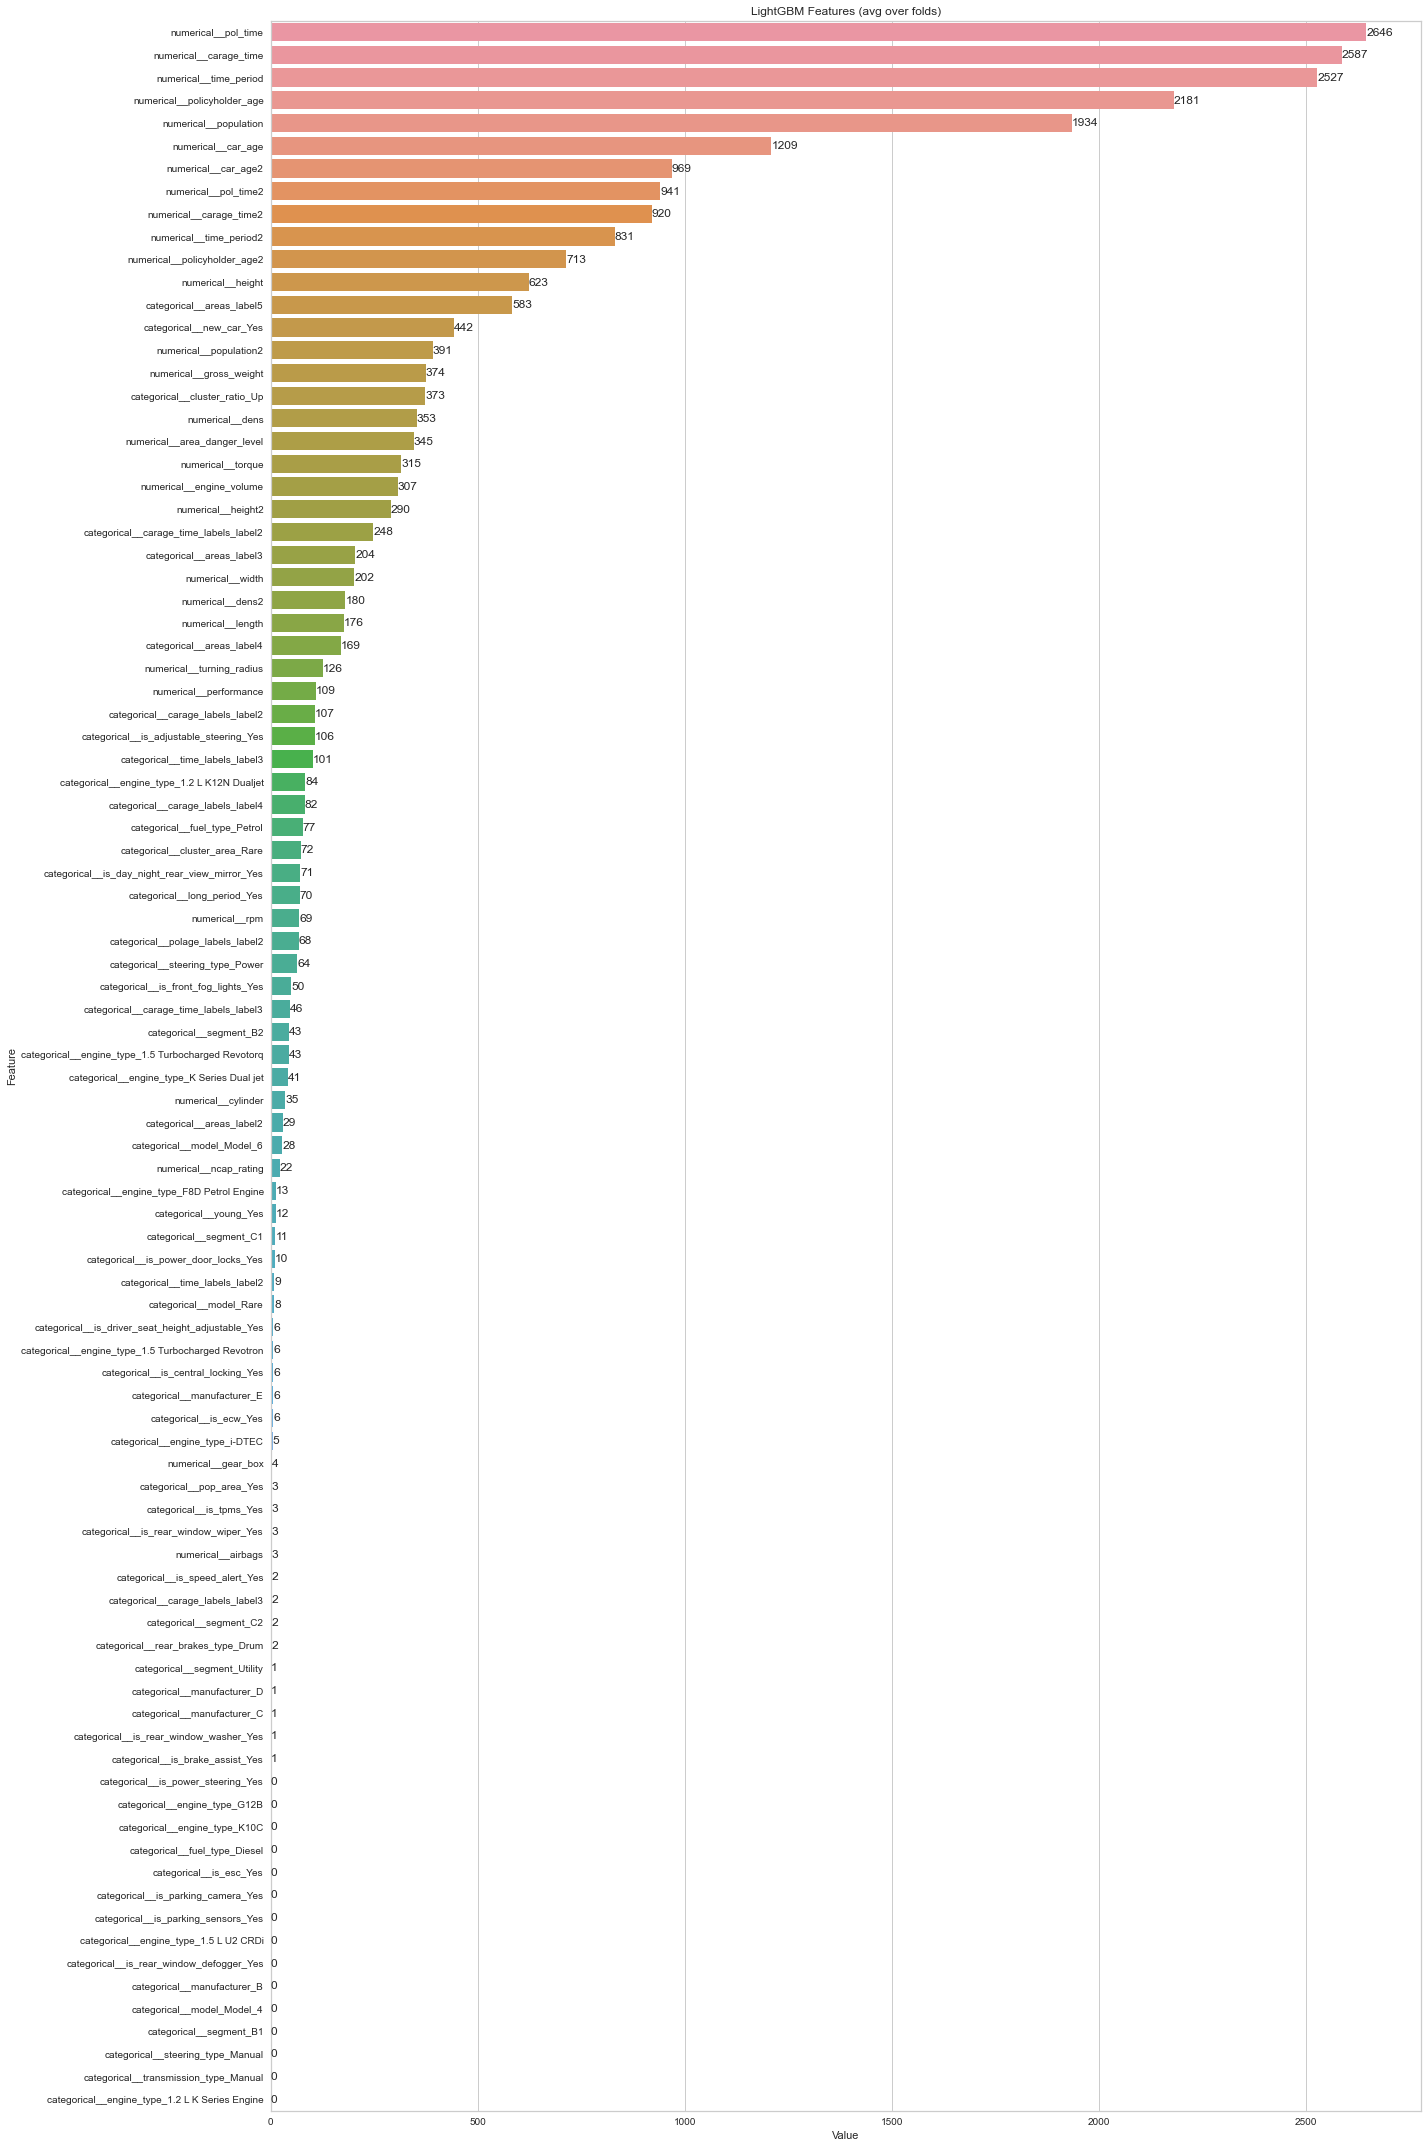

In [56]:
a = grid1.best_estimator_.named_steps.preprocessor.get_feature_names_out()
b = grid1.best_estimator_.named_steps.classifier.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(b,a)), columns=['Value','Feature'])

plt.figure(figsize=(20, 30))
ax = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
ax.bar_label(ax.containers[0])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [57]:
feature_imp[feature_imp.Value < 1].Feature.to_list()

['categorical__engine_type_1.2 L K Series Engine',
 'categorical__engine_type_1.5 L U2 CRDi',
 'categorical__engine_type_G12B',
 'categorical__engine_type_K10C',
 'categorical__fuel_type_Diesel',
 'categorical__is_esc_Yes',
 'categorical__is_parking_camera_Yes',
 'categorical__is_parking_sensors_Yes',
 'categorical__is_power_steering_Yes',
 'categorical__is_rear_window_defogger_Yes',
 'categorical__manufacturer_B',
 'categorical__model_Model_4',
 'categorical__segment_B1',
 'categorical__steering_type_Manual',
 'categorical__transmission_type_Manual']

In [58]:
# Checking the values to decide to drop or not:
feature_imp[feature_imp.Feature.str.contains("engine_type")]

,Value,Feature
0,0,categorical__engine_type_1.2 L K Series Engine
1,0,categorical__engine_type_1.5 L U2 CRDi
2,0,categorical__engine_type_G12B
3,0,categorical__engine_type_K10C
29,5,categorical__engine_type_i-DTEC
30,6,categorical__engine_type_1.5 Turbocharged Revo...
40,13,categorical__engine_type_F8D Petrol Engine
45,41,categorical__engine_type_K Series Dual jet
46,43,categorical__engine_type_1.5 Turbocharged Revo...
58,84,categorical__engine_type_1.2 L K12N Dualjet


**We will drop the variables with zero importance**

In [59]:
df_simple1 = df2.copy()

df_simple1.drop(columns=["transmission_type","is_rear_window_defogger","is_power_steering","is_parking_sensors",
                        "is_parking_camera","is_esc","is_brake_assist"],
                         axis=1,inplace=True)

**<span style="color:blue">Model-2</span>**

In [60]:
nums = []
cats = []

for i in df_simple1.columns:
        if df_simple1[i].dtype != "category" and i!="is_claim":
            nums.append(i)   
        elif i != "is_claim":
            cats.append(i)
            
print("Nums:", nums)
print("Cats:", cats)

Nums: ['ncap_rating', 'policyholder_age', 'car_age', 'height', 'torque', 'engine_volume', 'cylinder', 'population', 'time_period', 'length', 'width', 'gross_weight', 'gear_box', 'airbags', 'turning_radius', 'area_danger_level', 'performance', 'rpm', 'dens', 'pol_time', 'carage_time', 'policyholder_age2', 'car_age2', 'height2', 'population2', 'time_period2', 'dens2', 'pol_time2', 'carage_time2']
Cats: ['is_power_door_locks', 'rear_brakes_type', 'is_adjustable_steering', 'is_tpms', 'is_driver_seat_height_adjustable', 'segment', 'is_central_locking', 'is_rear_window_wiper', 'cluster_area', 'is_ecw', 'fuel_type', 'manufacturer', 'is_rear_window_washer', 'is_front_fog_lights', 'engine_type', 'is_speed_alert', 'steering_type', 'is_day_night_rear_view_mirror', 'model', 'cluster_ratio', 'time_labels', 'polage_labels', 'carage_labels', 'pol_time_labels', 'carage_time_labels', 'areas', 'new_car', 'young', 'long_period', 'pop_area']


In [62]:
train, test = train_test_split(df_simple1, test_size=0.10, random_state=42, stratify=df_simple1.is_claim)

y_train = train.is_claim
X_train = train.drop('is_claim', axis=1)
y_test = test.is_claim
X_test = test.drop('is_claim', axis=1)

# For the variables with high cardinality, we wanted to group the rare ones .
rare_encoder = RareLabelEncoder(tol=0.15, n_categories=6, variables=["cluster_area","model"])
rare_encoder.fit(X_train)
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

weights = np.linspace(0.80,0.99,19)

num_transformer = Pipeline(steps=[('scale',  QuantileTransformer(output_distribution='normal'))])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('categorical', cat_transformer, cats),
                                               ('numerical', num_transformer, nums)],
                                               remainder = 'passthrough') 

pipeline = Pipeline([('preprocessor' , preprocessor),
                       ('classifier' , LGBMClassifier(random_state=42,
                                                      boosting_type = "dart"))])

params = [{'classifier__subsample': [0.1,0.2],
           'classifier__n_estimators':[1300,1500,1800],
           'classifier__learning_rate': [0.005,0.008],
           'classifier__class_weight': [{0:x, 1:1.0-x} for x in weights],   
           'classifier__colsample_bytree':[0.3,0.4],
           'classifier__num_leaves':[17,18,19],
           'classifier__lambda_l1':[0.1,0.3],
           'classifier__lambda_l2':[2,2.5,3],
           'classifier__min_data_in_leaf':[30,40,50],
           'classifier__max_bin':[110000,120000,130000]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid2 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring=make_scorer(fbeta_score, beta=2))
           
model2 = grid2.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START classifier__class_weight={0: 0.9794444444444445, 1: 0.02055555555555555}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.3, classifier__lambda_l2=3, classifier__learning_rate=0.005, classifier__max_bin=110000, classifier__min_data_in_leaf=30, classifier__n_estimators=1500, classifier__num_leaves=19, classifier__subsample=0.1
[CV 1/2; 1/10] END classifier__class_weight={0: 0.9794444444444445, 1: 0.02055555555555555}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.3, classifier__lambda_l2=3, classifier__learning_rate=0.005, classifier__max_bin=110000, classifier__min_data_in_leaf=30, classifier__n_estimators=1500, classifier__num_leaves=19, classifier__subsample=0.1;, score=0.255 total time= 3.6min
[CV 2/2; 1/10] START classifier__class_weight={0: 0.9794444444444445, 1: 0.02055555555555555}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.3, classifier__lambda_l2=3, classifie

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[CV 1/2; 5/10] END classifier__class_weight={0: 0.8633333333333334, 1: 0.1366666666666666}, classifier__colsample_bytree=0.4, classifier__lambda_l1=0.3, classifier__lambda_l2=2, classifier__learning_rate=0.008, classifier__max_bin=120000, classifier__min_data_in_leaf=40, classifier__n_estimators=1800, classifier__num_leaves=17, classifier__subsample=0.2;, score=0.295 total time= 7.9min
[CV 2/2; 5/10] START classifier__class_weight={0: 0.8633333333333334, 1: 0.1366666666666666}, classifier__colsample_bytree=0.4, classifier__lambda_l1=0.3, classifier__lambda_l2=2, classifier__learning_rate=0.008, classifier__max_bin=120000, classifier__min_data_in_leaf=40, classifier__

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[CV 1/2; 9/10] END classifier__class_weight={0: 0.9477777777777778, 1: 0.05222222222222217}, classifier__colsample_bytree=0.4, classifier__lambda_l1=0.3, classifier__lambda_l2=3, classifier__learning_rate=0.005, classifier__max_bin=110000, classifier__min_data_in_leaf=30, classifier__n_estimators=1300, classifier__num_leaves=17, classifier__subsample=0.1;, score=0.293 total time= 6.9min
[CV 2/2; 9/10] START classifier__class_weight={0: 0.9477777777777778, 1: 0.05222222222222217}, classifier__colsample_bytree=0.4, classifier__lambda_l1=0.3, classifier__lambda_l2=3, classifier__learning_rate=0.005, classifier__max_bin=110000, classifier__min_data_in_leaf=30, classifier

In [63]:
pred_probs = model2.predict_proba(X_test)[:,1]
scores = print_results('Model-2', y_test, model2.predict(X_test), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
model_comparison = pd.concat([model_comparison, dftmp], ignore_index=True)
model_comparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
0,Model-1,0.503670,216.0,2101.0,1980.0,63.0,0.093224,0.774194,0.669195,0.114153,0.166410,0.314594
1,Model-2,0.455963,226.0,2319.0,1762.0,53.0,0.088802,0.810036,0.665037,0.109628,0.160057,0.308659


In [64]:
model2.best_params_

{'classifier__subsample': 0.1,
 'classifier__num_leaves': 17,
 'classifier__n_estimators': 1300,
 'classifier__min_data_in_leaf': 50,
 'classifier__max_bin': 130000,
 'classifier__learning_rate': 0.008,
 'classifier__lambda_l2': 2.5,
 'classifier__lambda_l1': 0.3,
 'classifier__colsample_bytree': 0.4,
 'classifier__class_weight': {0: 0.9266666666666666, 1: 0.07333333333333336}}

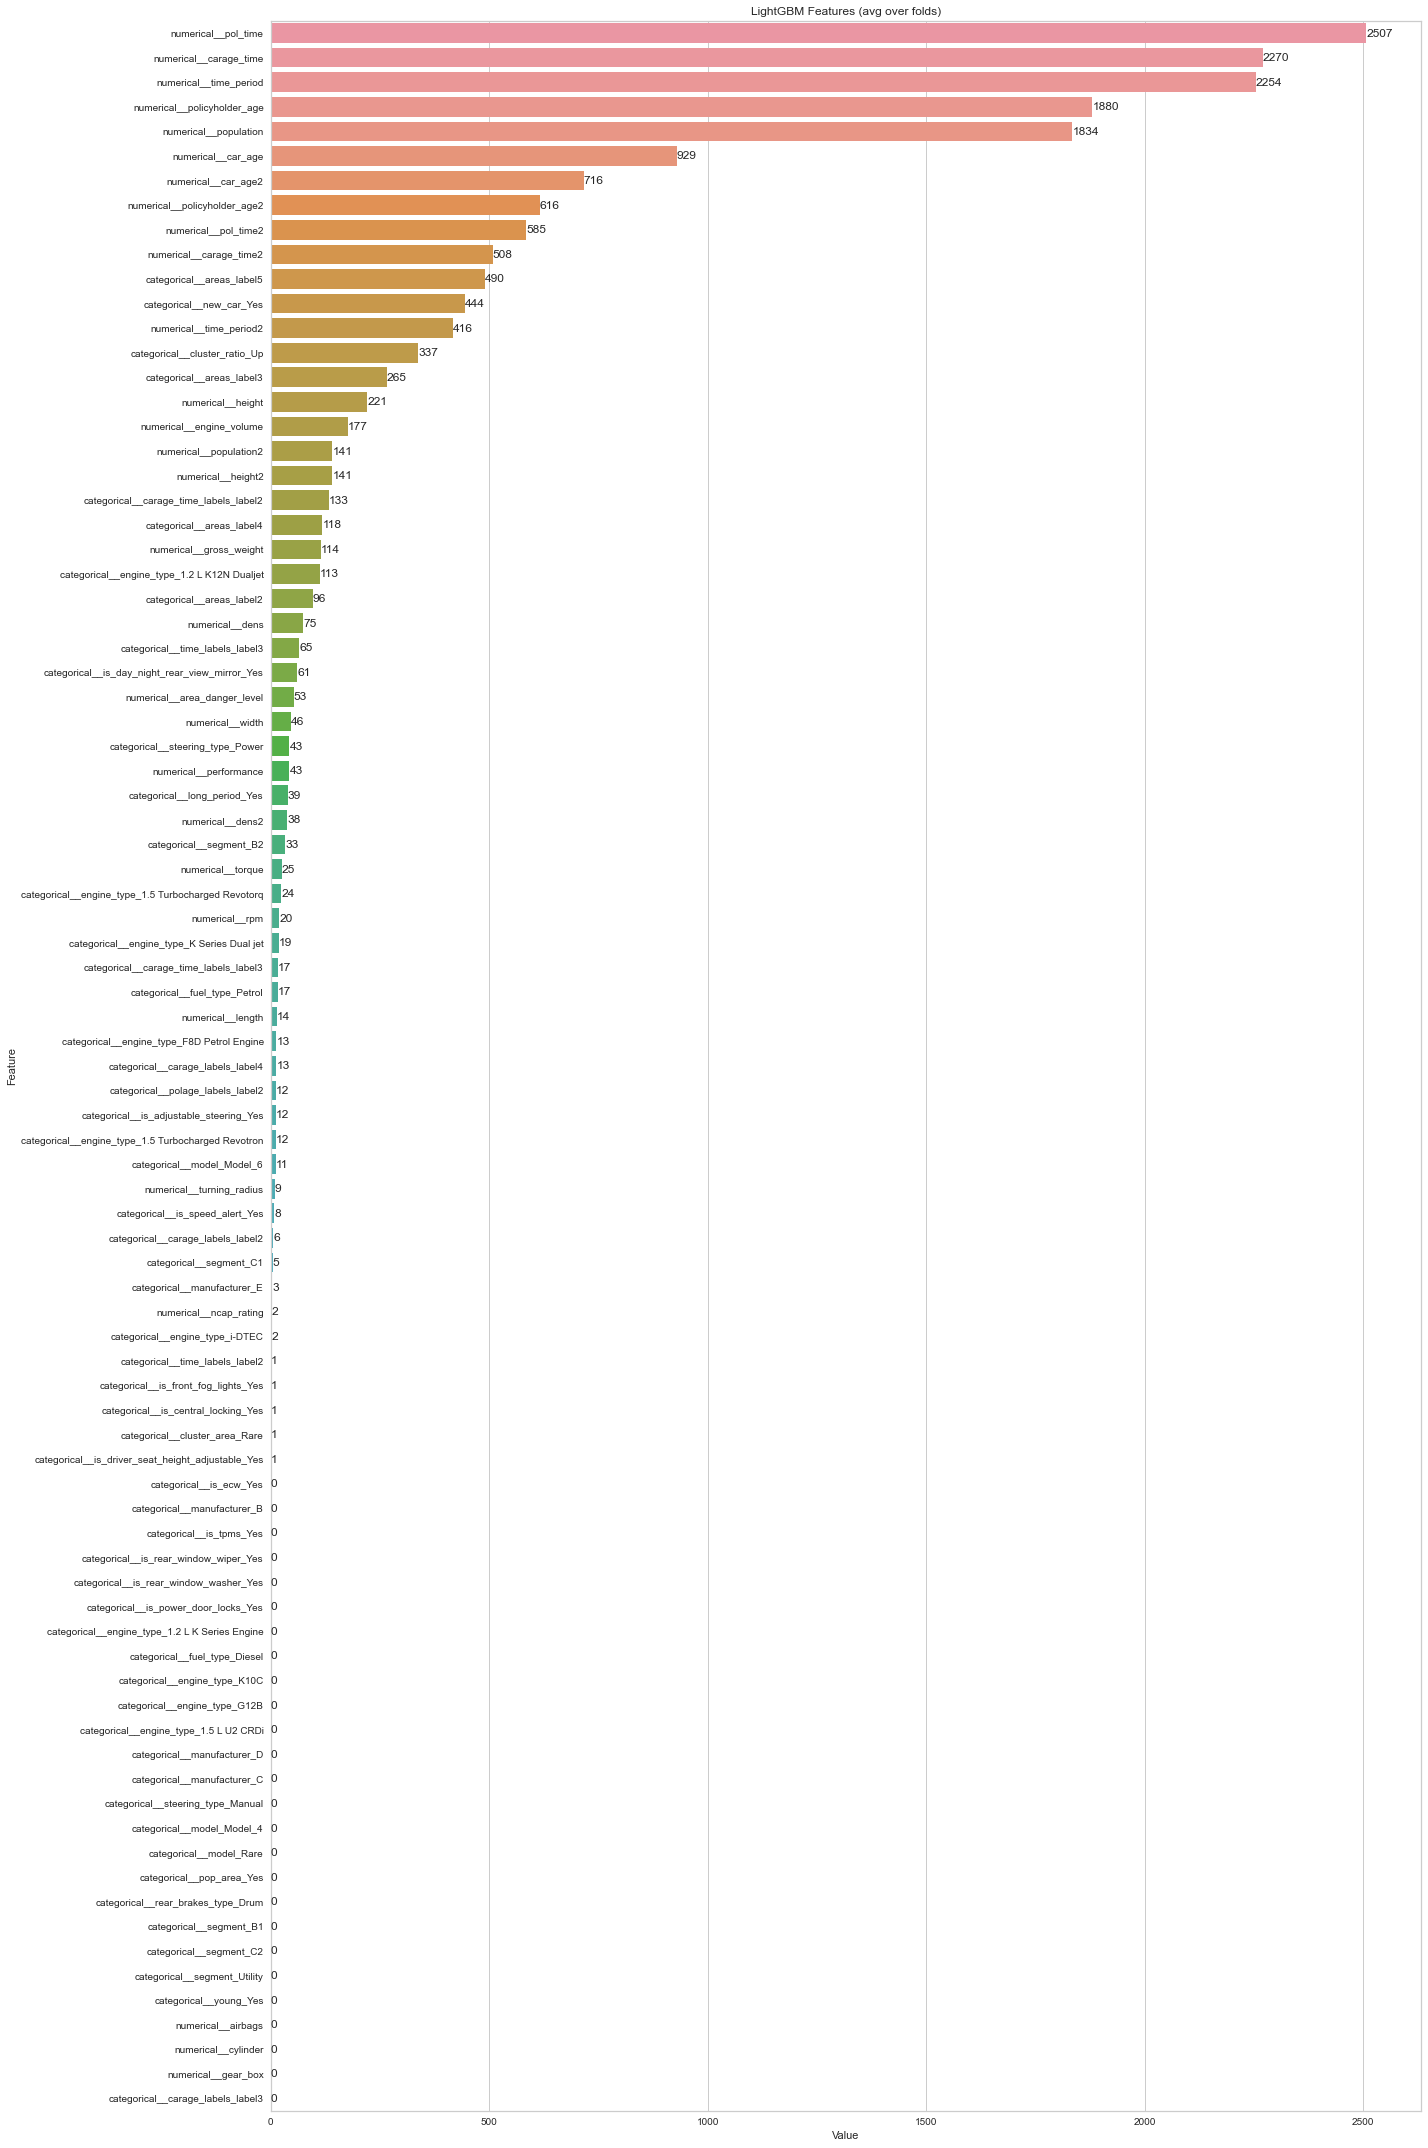

In [65]:
a1 = grid2.best_estimator_.named_steps.preprocessor.get_feature_names_out()
b1 = grid2.best_estimator_.named_steps.classifier.feature_importances_
feature_imp2 = pd.DataFrame(sorted(zip(b1,a1)), columns=['Value','Feature'])

plt.figure(figsize=(20, 30))
ax = sns.barplot(x="Value", y="Feature", data=feature_imp2.sort_values(by="Value", ascending=False))
ax.bar_label(ax.containers[0])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [66]:
feature_imp2[feature_imp2.Value < 1].Feature.to_list()

['categorical__carage_labels_label3',
 'categorical__engine_type_1.2 L K Series Engine',
 'categorical__engine_type_1.5 L U2 CRDi',
 'categorical__engine_type_G12B',
 'categorical__engine_type_K10C',
 'categorical__fuel_type_Diesel',
 'categorical__is_ecw_Yes',
 'categorical__is_power_door_locks_Yes',
 'categorical__is_rear_window_washer_Yes',
 'categorical__is_rear_window_wiper_Yes',
 'categorical__is_tpms_Yes',
 'categorical__manufacturer_B',
 'categorical__manufacturer_C',
 'categorical__manufacturer_D',
 'categorical__model_Model_4',
 'categorical__model_Rare',
 'categorical__pop_area_Yes',
 'categorical__rear_brakes_type_Drum',
 'categorical__segment_B1',
 'categorical__segment_C2',
 'categorical__segment_Utility',
 'categorical__steering_type_Manual',
 'categorical__young_Yes',
 'numerical__airbags',
 'numerical__cylinder',
 'numerical__gear_box']

In [67]:
feature_imp2[feature_imp2.Feature.str.contains("steering_type")]

,Value,Feature
21,0,categorical__steering_type_Manual
54,43,categorical__steering_type_Power


In [68]:
df_simple2 = df_simple1.copy()

df_simple2.drop(columns=["is_rear_window_washer","is_rear_window_wiper","pop_area"],
                         axis=1,inplace=True)

**<span style="color:blue">Model-3</span>**

In [69]:
nums = []
cats = []

for i in df_simple2.columns:
        if df_simple2[i].dtype != "category" and i!="is_claim":
            nums.append(i)   
        elif i != "is_claim":
            cats.append(i)


train, test = train_test_split(df_simple2, test_size=0.10, random_state=42, stratify=df_simple2.is_claim)

y_train = train.is_claim
X_train = train.drop('is_claim', axis=1)
y_test = test.is_claim
X_test = test.drop('is_claim', axis=1)

# For the variables with high cardinality, we wanted to group the rare ones .
rare_encoder = RareLabelEncoder(tol=0.15, n_categories=6, variables=["cluster_area","model"])
rare_encoder.fit(X_train)
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

weights = np.linspace(0.80,0.99,20)

num_transformer = Pipeline(steps=[('scale',  QuantileTransformer(output_distribution='normal'))])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('categorical', cat_transformer, cats),
                                               ('numerical', num_transformer, nums)],
                                               remainder = 'passthrough') 

pipeline = Pipeline([('preprocessor' , preprocessor),
                       ('classifier' , LGBMClassifier(random_state=42,
                                                      boosting_type = "dart"))])

params = [{'classifier__subsample': [0.2],
           'classifier__n_estimators':[1300,1400],
           'classifier__learning_rate': [0.006,0.008],
           'classifier__class_weight': [{0:x, 1:1.0-x} for x in weights],   
           'classifier__colsample_bytree':[0.3],
           'classifier__num_leaves':[18],
           'classifier__lambda_l1':[0.1],
           'classifier__lambda_l2':[2.5],
           'classifier__min_data_in_leaf':[30],
           'classifier__max_bin':[130000,140000,150000]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid3 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring=make_scorer(fbeta_score, beta=2))
           
model3 = grid3.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START classifier__class_weight={0: 0.99, 1: 0.010000000000000009}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.1, classifier__lambda_l2=2.5, classifier__learning_rate=0.006, classifier__max_bin=130000, classifier__min_data_in_leaf=30, classifier__n_estimators=1400, classifier__num_leaves=18, classifier__subsample=0.2
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=2.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5
[CV 1/2; 1/10] END classifier__class_weight={0: 0.99, 1: 0.010000000000000009}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.1, classifier__lambda_l2=2.5, classifier__learning_rate=0.006, classifier__max_bin=130000, classifier__min_data_in_leaf=30, 

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=2.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5
[CV 1/2; 5/10] END classifier__class_weight={0: 0.9, 1: 0.09999999999999998}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.1, classifier__lambda_l2=2.5, classifier__learning_rate=0.006, classifier__max_bin=150000, classifier__min_data_in_leaf=30, classifier__n_estimators=1300, classifier__num_leaves=18, classifier__subsample=0.2;, score=0.302 total time=  33.0s
[CV 2/2; 5/10] START classifier__class_weight={0: 0.9, 1: 0.09999999999999998}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.1, classifier__lambda_l2=2.5, classifier__learning_rate=0.006, classifier__max_bin=150000, classifier__min_data_in_leaf=30, classifier__n_estimators=1300, c

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=2.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5
[CV 1/2; 9/10] END classifier__class_weight={0: 0.89, 1: 0.10999999999999999}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.1, classifier__lambda_l2=2.5, classifier__learning_rate=0.006, classifier__max_bin=130000, classifier__min_data_in_leaf=30, classifier__n_estimators=1300, classifier__num_leaves=18, classifier__subsample=0.2;, score=0.299 total time=  38.2s
[CV 2/2; 9/10] START classifier__class_weight={0: 0.89, 1: 0.10999999999999999}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.1, classifier__lambda_l2=2.5, classifier__learning_rate=0.006, classifier__max_bin=130000, classifier__min_data_in_leaf=30, classifier__n_estimators=1300,

In [70]:
pred_probs = model3.predict_proba(X_test)[:,1]
scores = print_results('Model-3', y_test, model3.predict(X_test), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
model_comparison = pd.concat([model_comparison, dftmp], ignore_index=True)
model_comparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
0,Model-1,0.503670,216.0,2101.0,1980.0,63.0,0.093224,0.774194,0.669195,0.114153,0.166410,0.314594
1,Model-2,0.455963,226.0,2319.0,1762.0,53.0,0.088802,0.810036,0.665037,0.109628,0.160057,0.308659
2,Model-3,0.473394,225.0,2242.0,1839.0,54.0,0.091204,0.806452,0.666662,0.113649,0.163875,0.313983


In [71]:
model3.best_params_

{'classifier__subsample': 0.2,
 'classifier__num_leaves': 18,
 'classifier__n_estimators': 1400,
 'classifier__min_data_in_leaf': 30,
 'classifier__max_bin': 150000,
 'classifier__learning_rate': 0.008,
 'classifier__lambda_l2': 2.5,
 'classifier__lambda_l1': 0.1,
 'classifier__colsample_bytree': 0.3,
 'classifier__class_weight': {0: 0.92, 1: 0.07999999999999996}}

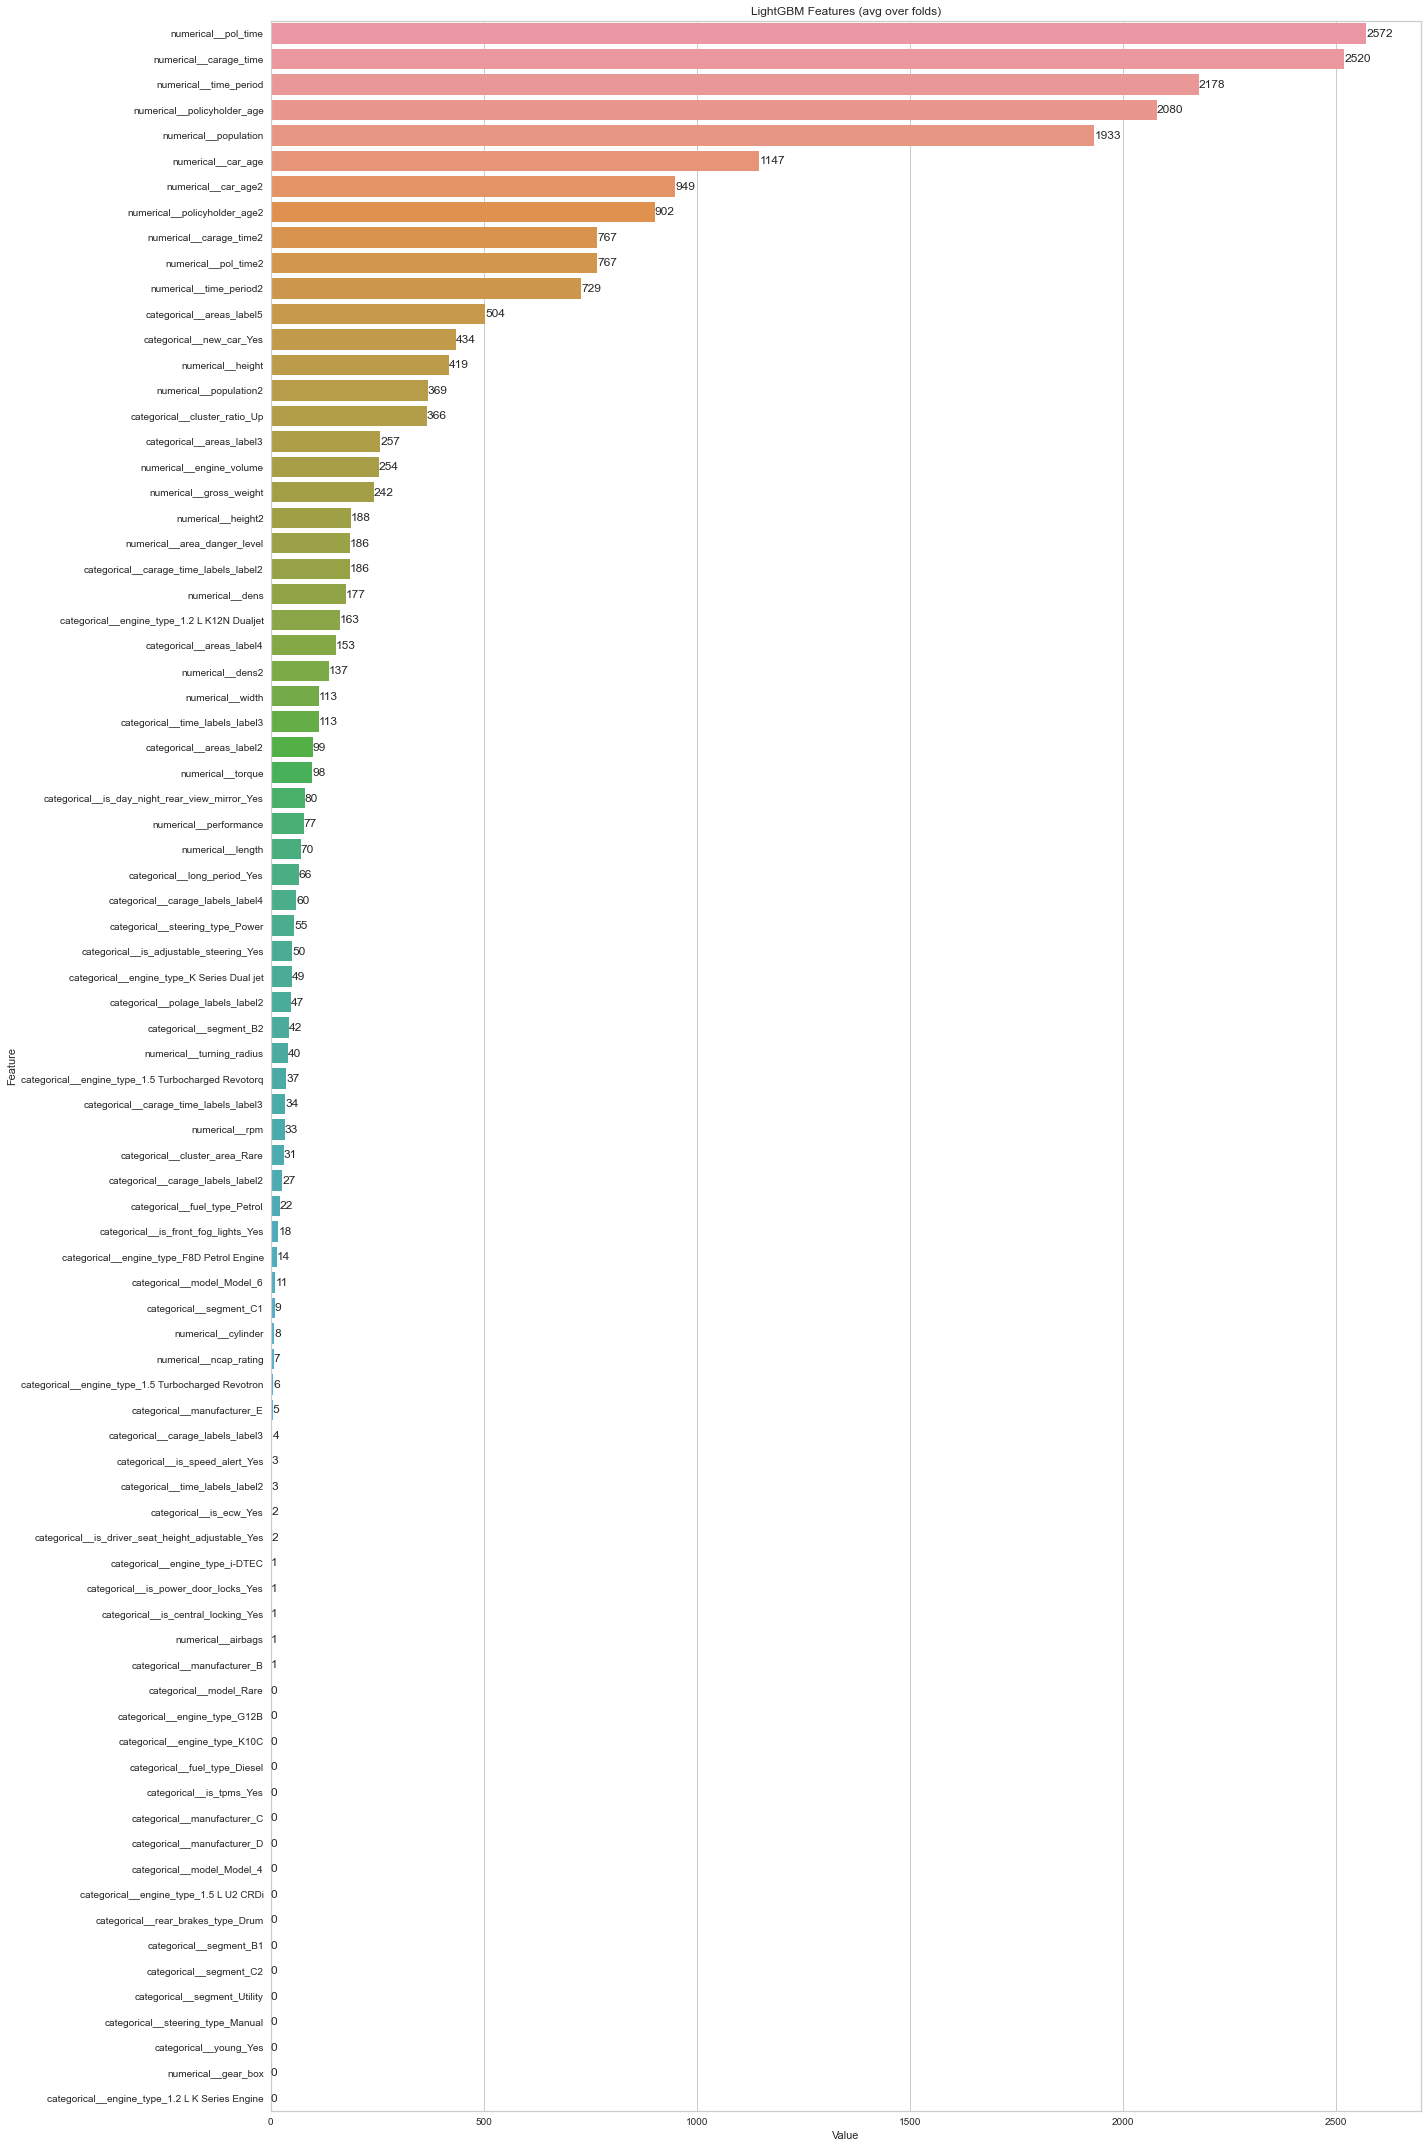

In [72]:
a2 = grid3.best_estimator_.named_steps.preprocessor.get_feature_names_out()
b2 = grid3.best_estimator_.named_steps.classifier.feature_importances_
feature_imp3 = pd.DataFrame(sorted(zip(b2,a2)), columns=['Value','Feature'])

plt.figure(figsize=(20, 30))
ax = sns.barplot(x="Value", y="Feature", data=feature_imp3.sort_values(by="Value", ascending=False))
ax.bar_label(ax.containers[0])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [73]:
feature_imp3[feature_imp3.Value < 1].Feature.to_list()

['categorical__engine_type_1.2 L K Series Engine',
 'categorical__engine_type_1.5 L U2 CRDi',
 'categorical__engine_type_G12B',
 'categorical__engine_type_K10C',
 'categorical__fuel_type_Diesel',
 'categorical__is_tpms_Yes',
 'categorical__manufacturer_C',
 'categorical__manufacturer_D',
 'categorical__model_Model_4',
 'categorical__model_Rare',
 'categorical__rear_brakes_type_Drum',
 'categorical__segment_B1',
 'categorical__segment_C2',
 'categorical__segment_Utility',
 'categorical__steering_type_Manual',
 'categorical__young_Yes',
 'numerical__gear_box']

In [74]:
feature_imp3[feature_imp3.Feature.str.contains("steering_type")]

,Value,Feature
14,0,categorical__steering_type_Manual
46,55,categorical__steering_type_Power


**<span style="color:blue">Model-4</span>**

In [75]:
# Scoring With Roc_auc

train, test = train_test_split(df_simple2, test_size=0.10, random_state=42, stratify=df_simple2.is_claim)

y_train = train.is_claim
X_train = train.drop('is_claim', axis=1)
y_test = test.is_claim
X_test = test.drop('is_claim', axis=1)

# For the variables with high cardinality, we wanted to group the rare ones .
rare_encoder = RareLabelEncoder(tol=0.15, n_categories=6, variables=["cluster_area","model"])
rare_encoder.fit(X_train)
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

weights = np.linspace(0.80,0.99,20)

num_transformer = Pipeline(steps=[('scale',  QuantileTransformer(output_distribution='normal'))])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('categorical', cat_transformer, cats),
                                               ('numerical', num_transformer, nums)],
                                               remainder = 'passthrough') 

pipeline = Pipeline([('preprocessor' , preprocessor),
                       ('classifier' , LGBMClassifier(random_state=42,
                                                      boosting_type = "dart"))])

params = [{'classifier__subsample': [0.2],
           'classifier__n_estimators':[1300],
           'classifier__learning_rate': [0.008],
           'classifier__class_weight': [{0:x, 1:1.0-x} for x in weights],   
           'classifier__colsample_bytree':[0.3],
           'classifier__num_leaves':[18],
           'classifier__lambda_l1':[0.1],
           'classifier__lambda_l2':[2.5],
           'classifier__min_data_in_leaf':[30],
           'classifier__max_bin':[130000]}]

kfold = StratifiedKFold(n_splits = 2, random_state = 42, shuffle=True)

grid4 = RandomizedSearchCV(pipeline, 
                           param_distributions= params, 
                           cv = kfold, 
                           n_iter= 10,
                           verbose = 10, 
                           scoring="roc_auc")
           
model4 = grid4.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START classifier__class_weight={0: 0.8300000000000001, 1: 0.16999999999999993}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.1, classifier__lambda_l2=2.5, classifier__learning_rate=0.008, classifier__max_bin=130000, classifier__min_data_in_leaf=30, classifier__n_estimators=1300, classifier__num_leaves=18, classifier__subsample=0.2
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=2.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5
[CV 1/2; 1/10] END classifier__class_weight={0: 0.8300000000000001, 1: 0.16999999999999993}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.1, classifier__lambda_l2=2.5, classifier__learning_rate=0.008, classifier__max_bin=130000, classif

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=2.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5
[CV 1/2; 5/10] END classifier__class_weight={0: 0.8200000000000001, 1: 0.17999999999999994}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.1, classifier__lambda_l2=2.5, classifier__learning_rate=0.008, classifier__max_bin=130000, classifier__min_data_in_leaf=30, classifier__n_estimators=1300, classifier__num_leaves=18, classifier__subsample=0.2;, score=0.647 total time=  44.1s
[CV 2/2; 5/10] START classifier__class_weight={0: 0.8200000000000001, 1: 0.17999999999999994}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.1, classifier__lambda_l2=2.5, classifier__learning_rate=0.008, classifier__max_bin=130000, classifier__min_data_in_leaf=30, cl

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=2.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5
[CV 1/2; 9/10] END classifier__class_weight={0: 0.86, 1: 0.14}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.1, classifier__lambda_l2=2.5, classifier__learning_rate=0.008, classifier__max_bin=130000, classifier__min_data_in_leaf=30, classifier__n_estimators=1300, classifier__num_leaves=18, classifier__subsample=0.2;, score=0.647 total time=  42.3s
[CV 2/2; 9/10] START classifier__class_weight={0: 0.86, 1: 0.14}, classifier__colsample_bytree=0.3, classifier__lambda_l1=0.1, classifier__lambda_l2=2.5, classifier__learning_rate=0.008, classifier__max_bin=130000, classifier__min_data_in_leaf=30, classifier__n_estimators=1300, classifier__num_leaves=18, cl

In [76]:
pred_probs = model4.predict_proba(X_test)[:,1]
scores = print_results('Model-4', y_test, model4.predict(X_test), pred_probs)
dftmp = pd.DataFrame([scores], columns=score_names)
model_comparison = pd.concat([model_comparison, dftmp], ignore_index=True)
model_comparison

,method,accuracy,TP,FP,TN,FN,precision,recall,roc_auc,pr_auc,f1,f2
0,Model-1,0.503670,216.0,2101.0,1980.0,63.0,0.093224,0.774194,0.669195,0.114153,0.166410,0.314594
1,Model-2,0.455963,226.0,2319.0,1762.0,53.0,0.088802,0.810036,0.665037,0.109628,0.160057,0.308659
2,Model-3,0.473394,225.0,2242.0,1839.0,54.0,0.091204,0.806452,0.666662,0.113649,0.163875,0.313983
3,Model-4,0.491972,217.0,2153.0,1928.0,62.0,0.091561,0.777778,0.666892,0.112685,0.163835,0.311245
